In [1]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import sqlalchemy as sa
import pyodbc
import pandas as pd

import numpy as np
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

from numba import njit, jit
from numba.core.errors import NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

from scipy.optimize import least_squares
from scipy import integrate

from joblib import Parallel, delayed
import json

import emcee
import corner

plt.style.use('lexi_plt_style.mplstyle')

In [2]:
def write_json(data, file_name):
    with open (file_name, 'w') as file:
        json.dump(data, file, indent = 4)

def open_json(file_name):
    with open (file_name) as file:
        return json.load(file)

We want to use a model to extract out the characteristic seed polymerization for each seed type using our length distribution histograms. To do this we will need to minimize $\chi^2$ relative to each fit parameter. In general $\chi^2$ is given by:

\begin{align*}
     \chi^2 = \frac{1}{n_{num}} \sum_{n=1}^{n_{tot}} \frac{(\textrm{data}_n - \textrm{model}_n)^2}{\textrm{variance}_n}
\end{align*}

where $n_{num}$ is the number of bins used. (For example if 1 of the bins is empty then $n$ would be 28 instead of the max 29. First lets grab out $data_n$ vector and our $variance_n$ vector.

First to get our raw data we connect to our local SQL server and make a function to run a quarry. 

In [3]:
conn_str = (
    r'driver={SQL Server};'
    r'server=Desktop_Name\SQLEXPRESS;' #update with the path to your server
    r'database=Database_name;' #update with the name of your database
    r'trusted_connection=yes;'
    )

#using SQLAlchemy to avoid a UserWarning
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_str})
engine = create_engine(connection_url) #create SQLAlchemy engine object

cnxn = pyodbc.connect(conn_str) #connect to server using pyodbc
cursor = cnxn.cursor()

def run_quary(quary_str):
    '''Run a quary and return the output as a pandas datafrme

    Args:
        quary_str (str): quary string (not case sensitive, SQL strings need to be enclosed in single quotes)

    Returns:
        dataframe: quary output
    '''
    with engine.begin() as conn:
        return pd.read_sql_query(sa.text(quary_str), conn)

Now lets make a data dictionary that will hold our relevant raw data (the numbers are the slide id of each sample we are using in this data set, and are the unique identifier we use to pull the right data from the server).

In [4]:
data = {'os p3024': {2023042700: {}, 2023042701: {}, 2023042702: {}, 2023042800: {}, 2023042801: {}, 2023042802: {}},
        'os s768': {2022102804: {}, 2022110107: {},  2022110108: {}},
        'os s576': {2022102803: {}, 2022110105: {}, 2022110106: {}},
        'os s384': {2022102802: {}, 2022110103: {}, 2022110104: {}},
        'ts p3024': {2023042703: {}, 2023042704: {}, 2023042705: {}},
        'ts s768': {2022111404: {}, 2022111405: {}, 2022111503: {}},
        'ts s576': {2023041900: {}, 2023041901: {}, 2023041902: {}},
        'ts s384': {2023042600: {}, 2023042601: {}, 2023042602: {}}}

seed_len_types = [ 'p3024', 's768', 's576', 's384']
pixel_per_um = 15.4792

#get sample data
for seed_len in seed_len_types:
    #one sided seed
    for slide_sample_id in data[f'os {seed_len}']:
        data_df = run_quary(f'Select * From length_distributions Where slide_sample_id = {slide_sample_id};').set_index('slide_sample_id') #get all one sided lengths 
        data[f'os {seed_len}'][slide_sample_id]['length_distribution'] = [len / pixel_per_um for len in data_df.loc[:]['lengths'].tolist()]

We have chosen to represent our one sided data as a histogram with 29 bins, from 1 $\mu m$ to 15 $\mu m$ so we are now going to collapse each slide sample into the same list of lengths (so we now have one list for each of the 4 seed types.

In [5]:
bins = [1 + i*0.5 for i in range(0,30)] #use the same bins for all plots
x_data = np.array([j+0.25 for j in bins[0:-1]]) #get x data points from the bins (center point of each bin)
colors = ['r', 'b', 'violet', 'orange']
mes_error = 8/pixel_per_um

def find_bin_count_error(len_dist):
    bin_count_error = []
    bin_half_width = (x_data[1]-x_data[0])/2
    for bin in x_data:
        bin_stack = []
        for len in len_dist:
            if len >= bin - bin_half_width and len <= bin + bin_half_width:
                bin_stack.append(len)
                len_dist.remove(len)
        s = 0
        for len in bin_stack:
            integrad = lambda z : (np.exp((-(len - z)**2)/(2 * mes_error**2)))/(np.sqrt(2 * np.pi) * mes_error)
            integral = integrate.quad(integrad, bin - bin_half_width, bin + bin_half_width)[0]
            s += integral * (1 - integral)
        bin_count_error.append(s)
    return bin_count_error

len_dists = []
for i in range(len(seed_len_types)): #for seed type
    len_dist = []
    seed_len = seed_len_types[i]
    for slide_sample_id in data[f'os {seed_len}']: #for each sample
        sample = data[f'os {seed_len}'][slide_sample_id]
        len_dist.extend(sample['length_distribution']) #combine the length distributions into one list
    
    len_dists.append(len_dist)

Rather than plotting a basic histogram, we want to plot the normalized frequency. To normalize we need to just divide each count by the area under the curve, which we will approximate using basic simpson's rule (https://en.wikipedia.org/wiki/Simpson%27s_rule)

\begin{align*}
    \int_a^b f(x) dx \approx \frac{b-a}{6} \left[f(a) + 4f\left(\frac{a+b}{2}\right) + f(b)\right]
\end{align*}

or in more explicit terms of our data

\begin{align*}
    \int_a^b f(x) dx \approx \frac{x_{data}[-1]-x_{data}[0]}{6} [y_{data}[0] + 4 y_{data}[n_{max} / 2] + y_{data}[-1]]
\end{align*}

To get the standard deviation for the normalized histogram bins we need to use error propagation. (n is the area under the curve, short for normalization constant)

\begin{align*}
    y_{norm} &= \frac{y}{n} \\
    \frac{\partial y_{norm}}{\partial n} &= -y (n)^{-2} \\
    \delta y_{norm} &= \sqrt{\left(\frac{\partial y_{norm}}{\partial n}\right)^2 (\delta n)^2} \\
    &= \frac{y \delta n}{n^2}
\end{align*}

To get this we need to find the error in the area under the curve, which will be dependent on the error in $fa$, $fm$, and $fb$ which are y_data at initial, middle, and final length.

\begin{align*}
    \delta n &= \sqrt{\left(\frac{\delta n}{\delta fa}\right)^2 \delta fa^2 + \left(\frac{\delta a}{\delta fm}\right)^2 \delta fm^2 + \left(\frac{\delta a}{\delta fb}\right)^2 \delta fb^2} \\
    &= (b-a) \sqrt{\frac{\delta fa^2}{36} + \frac{4}{9} \delta fm^2 + \frac{\delta fb^2}{36}}
\end{align*}

So the error bars (standard deviation) on our normalized histogram is given by

\begin{align*}
    \delta y_{norm} &= \frac{y (b-a)}{n^2} \sqrt{\frac{\delta fa^2}{36} + \frac{4}{9} \delta fm^2 + \frac{\delta fb^2}{36}}
\end{align*}

In [6]:
basic_simp = njit(lambda x, f : ((x[-1] - x[0])/6) * (f[0] + 4 * f[int(len(x)/2)] + f[-1]))

def find_hist_error(x, y, y_err):
    return ((y * (x[-1] - x[0]))/(basic_simp(x, y)**2)) * np.sqrt((y_err[0]**2)/36 + (4*y_err[int(len(x)/2)]**2)/9 + (y_err[-1]**2)/36)

def get_ydata(len_dist):
    y_data, _= np.histogram(len_dist, bins = bins) #grab the resulting y points by plotting the histogram
    normed_y_data = y_data/basic_simp(x_data, y_data) #normalize the data
    return normed_y_data

def get_yerror(len_dist):
    y_data, _= np.histogram(len_dist, bins = bins) #grab the resulting y points by plotting the histogram
    y_error = find_bin_count_error(len_dist)
    
    normed_y_error = find_hist_error(x_data, y_data, y_error)

    return normed_y_error

In [7]:
y_data_sets = [get_ydata(len_dists[i]) for i in range(len(seed_len_types))]
y_error_sets = [get_yerror(len_dists[i]) for i in range(len(seed_len_types))]

Lets make a function for plotting data as a histogram for ease

In [8]:
def plot_hist(y_data_sets, y_error_sets, axs, boot=False):
    for i in range(len(seed_len_types)): #for each seed type
        y_axis = [0,0,1,1][i] #determine which quadrant the plot goes in
        x_axis = [0,1,0,1][i]

        y_data = y_data_sets[i] #get the seed's y data
        y_error = y_error_sets[i] #get the seed's error bars

        axs[y_axis, x_axis].bar(x_data, y_data, alpha = 0.3, label = 'SEs', color = 'g', yerr = y_error, width = 0.5, capsize = 5)
        axs[y_axis, x_axis].set_title(seed_len_types[i])
        axs[y_axis, x_axis].set_xlim(1,15)
        if boot:
            axs[y_axis, x_axis].set_ylim(0,0.9)
        else:
            axs[y_axis, x_axis].set_ylim(0,0.55)
        axs[y_axis, x_axis].set_xticks(np.arange(1, 16, step = 1), np.arange(1, 16, step = 1))
        axs[y_axis, x_axis].legend(prop={'size': 25}, frameon=False)

    axs[1,0].set_xlabel('Length ($\mu m$)', fontsize = 20)
    axs[1,0].set_ylabel('Normalized Frequency', fontsize = 20)

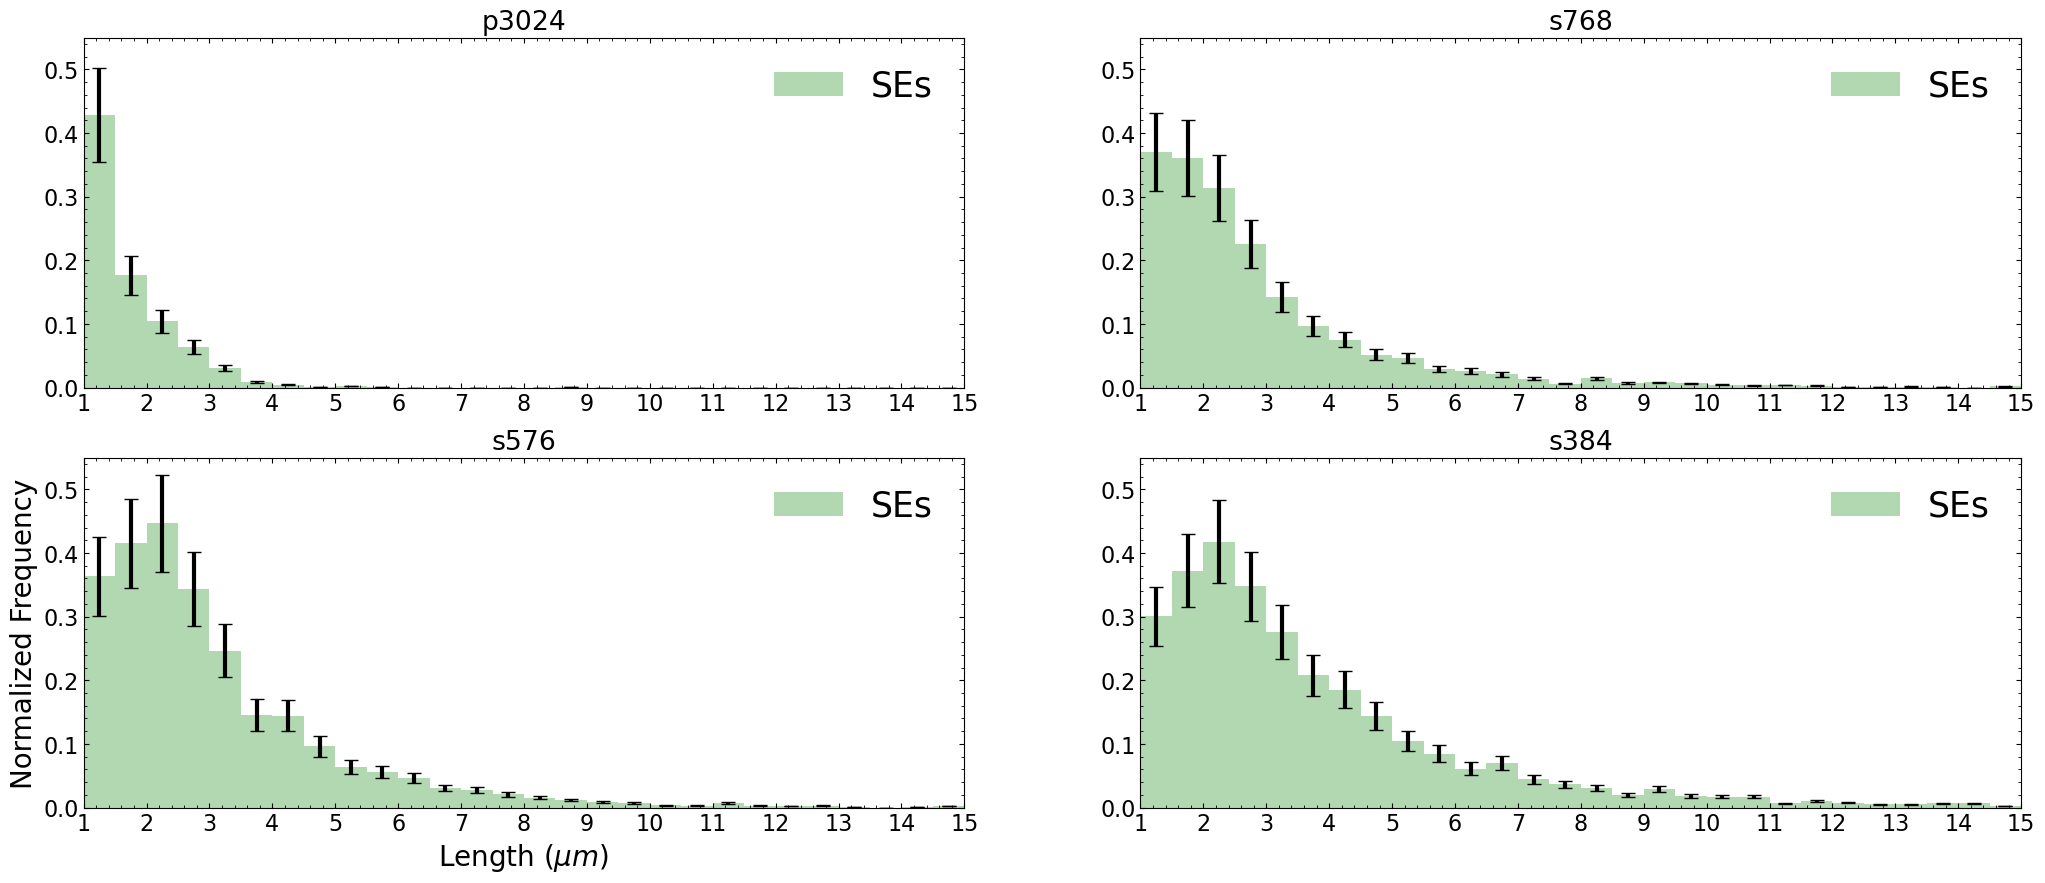

In [9]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
plot_hist(y_data_sets, y_error_sets, axs)
plt.show()

Now that we have our data and variance vectors, we need to describe our model so that we can create our model vector. The model we are using is describe in this paper: A coarse-grained model captures the temporal evolution of DNA nanotube length distributions

This models the behavior of a histogram of the length distribution over time, rather than the entire length distribution. The larger the bin width, the more coarse grain the model is.

The free tile concentration is described with one ODE: 

\begin{align*}
    \frac{d[T]}{dt} &= a(t) - d(t) - N_{nucl} k_{nucl} [T]^{N_{nucl}} - N_b k_p [T] \sum_{i = 1}^{n_{max} -1} [L_i] - (Nb - N_{nucl}) k_{p_0} [T] [L_0] \\
    &+ N_b k_d \sum_{i=2}^{n_{max}} [L_i] + (N_b - N_{nucl}) k_d [L_1] + N_{nucl} k_{d_0} [L_0]
\end{align*}

where $a(t)$ is the rate off added tiles, $d(t)$ is the rate of tile removal, $N_{nucl}$ is the characteristic size of a nucleation site (how many tiles have to come together at once to create a nucleation site), $k_{nucl}$ is the rate of nucleation, $N_b$ is the bin width in number of tiles (how many tiles a tube would need to grow to move from one bin to another), $k_p$ is the rate of polymerization, $k_{p_0}$ is the rate of polymerization from a nucleation site, $k_d$ is teh rate of depolymerization, and $k_{d_0}$ is the rate of depolymerization of a nucleation site (when a nucleation site turns back into free tiles).

Then the concentration of nucleation sites $[L_0]$ is described by another ODE.

\begin{align*}
    \frac{d[L_0]}{dt} &= k_{nucl} [T]^{N_{nucl}} - k_{p_0} [T] [L_0] + k_d [L1] - k_{d_0} [L_0]
\end{align*}

Finally the concentration of the $i$th bin in the histogram $[L_i]$ is described with a system of ODEs.

\begin{align*}
    \frac{d[L_1]}{dt} = &k_{p_0} [T] [L_0] - k_p [T] [L_1] + k_d [L_2] - k_d [L_1] - 2 \sum_{m=1}^{n_{max} -1} k_{join}(1,m)[L_1][L_m] \\
    &- 2k_{join}(1,1)[L_1]^2 + 2 \sum_{m=2}^{n_{max}} k_{break} (L_m \rightarrow L_1 + L_{m-1}) [L_m] \\
    \frac{d[L_n]}{dt} = &k_p [T] ([L_{n-1}] - [L_{n|n < n_{max}}]) + k_d ([L_{n+1|n < n_{max}}] - [L_n]) \\
    &- 2 \sum_{m=1}^{n_{max} -n} k_{join}(n,m) [L_n] [L_m] - 2 k_{join} (n,n) [L_{n|n \leq \frac{n_{max}}{2}}]^2 + 2 \sum_{m=1}^{\frac{n}{2}} k_{join} (n-m,m)[L_{n-m}][L_m] \\
    &+ 2 \sum_{m \geq n+1}^{n_{max}} k_{break} (L_m \rightarrow L_n + L_{m-n})[L_m] - (n-1) k_{break} (L_n \rightarrow L_m + L_{n-m})[L_n]
\end{align*}

Where $k_{break}$ is the rate of a tube breaking into 2 tubes of different sizes and $k_{join}$ is the rate of 2 tubes end to end joining together and is further described as

\begin{align*}
    k_{join}(m,n) &= N_A \frac{\alpha}{l_b} \left[\frac{1}{m} \ln\left(\frac{m l_b}{d}\right) + \frac{1}{n} \ln\left( \frac{n l_b}{d} \right) \right]
\end{align*}

$N_a$ is avogadro's number, $l_b$ is the bin width in nm, and $d$ is the nanotube diameter in nanometers, and we will be using $N_a \alpha$ as the fit parameter.

Now we need to adopt this model to fit our system so we will make the following assumptions:
- we are not changing the tile concentration over time so $a(t) = d(t) = 0$
- $k_{break}$ is constant (they also make this assumption in their paper when they fit)
- all of our nucleation sites $[L_0]$ are seeds rather than forming from spontaneous nucleation
- therefore the characteristic nucleation site size is equal to the size of the seed in tiles (64, 18, 14, 9 for p3024, s769, s567, and s384)
- we are working at low enough tile concentrations that no spontaneous nucleation occurs aka $k_{nucl} = 0$
- the nucli (our seeds) are not unfolding aka $k_{d_0} = 0$
- no end to end joining b/c non-homogenous tubes cannot join

Since our histogram bins are 0.5nm wide and we have 29 of them in total: 
- $N_b$ = 420 tiles
- $l_b$ = 0.5 nm
- $d$ = 13 nm
- $n_{max}$ = 29

This leaves us with 5 fit parameters: $k_p$, $k_{p_0}$, $k_d$, $N_a \alpha$, and $k_{break}$ and the above equations simply to:

\begin{align*}
    \frac{d[T]}{dt} &= - N_b k_p [T] \sum_{i = 1}^{n_{max} -1} [L_i] - (Nb - N_{nucl}) k_{p_0} [T] [L_0] + N_b k_d \sum_{i=2}^{n_{max}} [L_i] + (N_b - N_{nucl}) k_d [L_1] \\
    \frac{d[L_0]}{dt} &= - k_{p_0} [T] [L_0] + k_d [L1] \\
    \frac{d[L_1]}{dt} &= k_{p_0} [T] [L_0] - k_p [T] [L_1] + k_d [L_2] - k_d [L_1] + 2 \sum_{m=2}^{n_{max}} k_{break} [L_m] \\
    \frac{d[L_n]}{dt} &= k_p [T] ([L_{n-1}] - [L_{n|n < n_{max}}]) + k_d ([L_{n+1|n < n_{max}}] - [L_n]) + 2 \sum_{m \geq n+1}^{n_{max}} k_{break} [L_m] - (n-1) k_{break} [L_n]
\end{align*}

Rather than trying to solve 31 couple ODEs, we are going to use Eurler's Method to approximate the ODEs over time: $y_{n+1} = y_n + h \frac{d y_n}{dt}$. To get the height of the histogram bin returned by the model, we pull the height found at the last time step taken. To determine the total time we should estimate the ODE over, we use the time between the samples being held and 31C and when they were imaged (1 day for all samples). 

In [10]:
conts = [420.0, 0.5, 13.0, 29.0, 24.0 * 60.0 * 60.0, 100000.0] #tiles, nm bin width, nm nanotube diameter, 1 day in second, num steps
conts.append(conts[4]/conts[5]) #h
conts.append(0.3 * 10**(-9))#initial seed concentration 0.3nM

N_nucls = np.array([64, 18, 14, 9])

We will represent our model using a 2d matrix where the first dimension is the time step and the second dimension is the nth bin (0 is the seed concentration, n_{max} + 1 is the free tile concentration). So we we will re-write our model equations as:

\begin{align*}
    \frac{dL[t,n_{max}+1]}{dt} &= - N_b k_p L[t,n_{max} + 1] \sum_{n = 1}^{n_{max} -1} L[t,n] - (N_b - N_{nucl}) k_{p_0} L[t,n_{max} + 1] L[t,0] \\
    &+ N_b k_d \sum_{n=2}^{n_{max}} L[t, n] + (N_b - N_{nucl}) k_d L[t, 1] \\
    \frac{dL[t,0]}{dt} &= - k_{p_0} L[t, n_{max} + 1] L[t,0] + k_d L[t,1] \\
    \frac{dL[t,1]}{dt} &= k_{p_0} L[t,n_{max} + 1] L[t,0] - k_p L[t,n_{max} + 1] L[t,1] + k_d L[t,2] \\
    &- k_d L[t,1] + 2 \sum_{m=2}^{n_{max}} k_{break} L[t,m] \\
    \frac{dL[t,n]}{dt} &= k_p L[t,T] (L[t, n-1] - L[t, n|n < n_{max}]) + k_d (L[t,n+1|n < n_{max}] - L[t,n]) \\
    &+ 2 \sum_{m \geq n+1}^{n_{max}} k_{break} L[t,m] - (n-1) k_{break} L[t,n]
\end{align*}

Note that later on our goal will be to find the best fit parameters, which will require takeing partial derivatives of the above expressions with respect to each of the fit parameters. While these equations certainty aren't simple, they are nicely linear with respect to the fit parameters. Therefore, for example, $\frac{dL[t,0]}{dt} = k_{p_0} \frac{\partial}{\partial k_{p_0}} \frac{dL[t,0]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{dL[t,0]}{dt}$. While this doesn't look like a simplification in the moment, we will need to write functions for each of these partial derivatives later on. Therefore to avoid having to write these expressions in python twice, we will re-write the model in terms of its partial derives. This way our model function and our partial $\chi^2$ functions can reference the same partial derivative functions.

\begin{align*}
    \frac{dL[t,n_{max} + 1]}{dt} &= k_p \frac{\partial}{\partial k_p} \frac{dL[t,n_{max} + 1]}{dt} + k_{p_0} \frac{\partial}{\partial k_{p_0}} \frac{dL[t,n_{max} + 1]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{dL[t,n_{max} + 1]}{dt} \\
    \frac{dL[t,0]}{dt} &= k_{p_0} \frac{\partial}{\partial k_{p_0}} \frac{dL[t,0]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{dL[t,0]}{dt} \\
    \frac{dL[t,1]}{dt} &= k_{p_0} \frac{\partial}{\partial k_{p_0}} \frac{dL[t,1]}{dt} - k_p \frac{\partial}{\partial k_p} \frac{dL[t,1]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{dL[t,1]}{dt} + k_{break} \frac{\partial}{\partial k_{break}} \frac{dL[t,1]}{dt}\\
    \frac{dL[t,n]}{dt} &= k_p \frac{\partial}{\partial k_p} \frac{dL[t,n]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{dL[t,n]}{dt} + k_{break} \frac{\partial}{\partial k_{break}} \frac{dL[t,n]}{dt}
\end{align*}

Where 

\begin{align*}
    \frac{\partial}{\partial k_p} \frac{dL[t,n_{max} + 1]}{dt} &= -N_b L[t,n_{max} + 1] \sum_{n=1}^{n_{max} -1} L[t,n] \\
    \frac{\partial}{\partial k_p} \frac{dL[t,0]}{dt} &= 0 \\
    \frac{\partial}{\partial k_p} \frac{dL[t,1]}{dt} &= -L[t, 30] L[t,1] \\
    \frac{\partial}{\partial k_p} \frac{dL[t,1 < n < n_{max}]}{dt} &= L[t,n_{max} + 1] (L[t,n-1] - L[t,n])\\
    \frac{\partial}{\partial k_p} \frac{dL[t,n_{max}]}{dt} &= L[t,n_{max} + 1] L[t,n_{max} - 1] 
\end{align*}

In [11]:
@njit
def part_kp(L_vec, n, cont):
    if n == int(cont[3]) + 1:
        return -cont[0] * L_vec[int(cont[3]) + 1] * np.sum(L_vec[1:int(cont[3])])
    elif n==0:
        return 0
    elif n==1:
        return -L_vec[int(cont[3]) + 1] * L_vec[1]
    elif n==int(cont[3]):
        return L_vec[int(cont[3]) + 1] * L_vec[int(cont[3]) -1]
    else: #for 1<n<n_max
        return L_vec[int(cont[3]) + 1] * (L_vec[n-1] - L_vec[n])

\begin{align*}
    \frac{\partial}{\partial k_{p_0}} \frac{dL[t,n_{max} + 1]}{dt} &= - (N_b -N_{nucl}) L[t,n_{max} + 1] L[t,0] \\
    \frac{\partial}{\partial k_{p_0}} \frac{dL[t,0]}{dt} &= -L[t,n_{max} + 1] L[t,0] \\
    \frac{\partial}{\partial k_{p_0}} \frac{dL[t,1]}{dt} &= L[t,n_{max} + 1] L[t,0]  \\
    \frac{\partial}{\partial k_{p_0}} \frac{dL[t,1 < n < n_{max} + 1]}{dt} &= 0
\end{align*}

In [12]:
@njit
def part_kp0(L_vec, n, N_nucl, cont):
    if n==int(cont[3]) + 1:
        return -(cont[0] - N_nucl) * L_vec[int(cont[3]) + 1] * L_vec[0]
    elif n==0:
        return -L_vec[int(cont[3]) + 1] * L_vec[0]
    elif n==1:
        return L_vec[int(cont[3]) + 1] * L_vec[0]
    else: #1<n<n_max + 1
        return 0

\begin{align*}
    \frac{\partial}{\partial k_d} \frac{dL[t,n_{max} + 1]}{dt} &= N_b \sum_{n=2}^{n_{max}} L[t,n] + (N_b - N_{nucl}) L[t,1] \\
    \frac{\partial}{\partial k_d} \frac{dL[t,0]}{dt} &= L[t,1] \\
    \frac{\partial}{\partial k_d} \frac{dL[t,1]}{dt} &= L[t,2] - L[t,1]  \\
    \frac{\partial}{\partial k_d} \frac{dL[t,1 < n < n_{max}]}{dt} &= L[t, n+1] - L[t,n] \\
    \frac{\partial}{\partial k_d} \frac{dL[t,n_{max}]}{dt} &= -L[t,n_{max}]
\end{align*}

In [13]:
@njit
def part_kd(L_vec, n, N_nucl, cont):
    if n==int(cont[3]) + 1:
        return cont[0] * np.sum(L_vec[2:int(cont[3]) + 1]) + (cont[0] - N_nucl) * L_vec[1]
    elif n==0:
        return L_vec[1]
    elif n==1:
        return L_vec[2] - L_vec[1]
    elif n==int(cont[3]):
        return -L_vec[int(cont[3])]
    else: #1<n<n_max
        return L_vec[n+1] - L_vec[n]

\begin{align*}
    \frac{\partial}{\partial k_{break}} \frac{dL[t,n_{max} + 1]}{dt} &= \frac{\partial}{\partial k_{break}} \frac{dL[t,0]}{dt} = 0 \\
    \frac{\partial}{\partial k_{break}} \frac{dL[t,1]}{dt} &= 2 \sum_{m=2}^{n_{max}} L[t,m] \\
    \frac{\partial}{\partial k_{break}} \frac{dL[t,n>1]}{dt} &= 2 \sum_{m \geq n+1}^{n_{max}} L[t,m] - (n-1) L[t,n]
\end{align*}

In [14]:
@njit
def part_kbreak(L_vec, n, cont):
    if n==(int(cont[3]) + 1) or n==0:
        return 0
    else:
        return 2 * np.sum(L_vec[n+1:int(cont[3]) + 1]) - (n-1) * L_vec[n]

In [15]:
@njit
def part_dL(L_vec, n, N_nucl, par_div, cont):
    if par_div == 'kp':
        return part_kp(L_vec, n, cont)
    elif par_div == 'kp0':
        return part_kp0(L_vec, n, N_nucl, cont)
    elif par_div == 'kd':
        return part_kd(L_vec, n, N_nucl, cont)
    elif par_div == 'kbreak':
        return part_kbreak(L_vec, n, cont)

In [16]:
@njit
def dL(L_vec, parr, N_nucl, cont):
    dL_vec = np.zeros(int(cont[3]) + 2) #create an empty dL vector

    for n in range(int(cont[3]) + 2):
        dL_vec[n] = parr[0] * part_dL(L_vec, n, N_nucl, 'kp', cont) + parr[1] * part_dL(L_vec, n, N_nucl, 'kp0', cont) + parr[2] * part_dL(L_vec, n, N_nucl, 'kd', cont) + parr[3] * part_dL(L_vec, n, N_nucl, 'kbreak', cont)
    
    return dL_vec

In order to pass an L vector to the above function we need to write to express $L[t_f, n]$ using the Eurler approximation.
\begin{align*}
    L[t_f, n] &= L[t_f -1, n] + h \frac{d L[t_f - 1, n]}{dt} \\
    &= L[t_f -2, n] + h \frac{d L[t_f - 2, n]}{dt} + h \frac{d L[t_f - 1, n]}{dt} \\
    &= L[t_0, n] + h \sum_{t=0}^{t_{f}-1} \frac{dL[t,n]}{dt}
\end{align*}

In [17]:
@njit
def L(parr, N_nucl, cont):
    L_mat = np.zeros((int(cont[5]), int(cont[3]) + 2)) #we use this matrix to preserve the time evolution of the model
    L_mat[0,int(cont[3]) + 1] = 100 * 10**(-9) #initial [T] 100nM
    L_mat[0,0] = cont[7]

    L_vec = np.zeros(int(cont[3]) + 2)
    L_vec[int(cont[3]) + 1] = 100 * 10**(-9)
    L_vec[0] = cont[7]
    for t_step in range(1,int(cont[5])):
        L_vec += cont[6] * dL(L_vec, parr, N_nucl, cont) #L_vec is from the prvious loop so this is calling dL at t_step-1
        L_mat[t_step,:] = L_vec    
    return L_mat

Before we try to minimize the $\chi^2$ lets demonstrate that this code works for an example set of parameters

In [18]:
chain_start = np.array([[1*(10**6), 5*10**5, 5*10**(-5),10**(-8)], 
                    [1*(10**6), 5*(10**4), 5*10**(-5),10**(-8)],
                    [1*(10**6), 3*(10**4), 5*10**(-5),10**(-8)],
                    [1*(10**6), 2*(10**4), 5*10**(-5),10**(-8)]])

Lets make some more graphing function for ease.

In [19]:
def plot_time_dependence(models, cont):
    if int(cont[3]) == 29:
        fig = plt.figure(figsize=(21, 18))
        ax1 = plt.subplot(6,1,1)
        axs = [ax1]
        for i in range(7, 37):
            axs.append(plt.subplot(6, 6, i))
        
        for j in range(len(seed_len_types)):
            seed_len = seed_len_types[j]
            axs[0].plot(models[j][:,int(cont[3])], color = colors[j], label = seed_len)
            axs[0].set_title('[T]')

            axs[1].plot(models[j][:,0], color = colors[j], label = seed_len)
            axs[1].set_title('[L0]')
        
            axs[2].plot(models[j][:,1], color = colors[j], label = seed_len)
            axs[2].set_title('[L1]')

            for i in range(2,int(cont[3])+1):
                axs[i+1].plot(models[j][:,i], color = colors[j], label = seed_len)
                axs[i+1].set_title(f'[L{i}]')
        fig.tight_layout()
        axs[0].legend()

    elif int(cont[3]) == 12:
        fig, axs =  plt.subplots(2,7, figsize = (18,8))
        for j in range(len(seed_len_types)):
            seed_len = seed_len_types[j]
            axs[0,0].plot(models[j][:,int(cont[3])], color = colors[j], label = seed_len)
            axs[0,0].set_title('[T]')

            axs[0,1].plot(models[j][:,0], color = colors[j], label = seed_len)
            axs[0,1].set_title('[L0]')

            axs[0,2].plot(models[j][:,1], color = colors[j], label = seed_len)
            axs[0,2].set_title('[L1]')

            for i in range(2,int(cont[3])+1):
                if int(cont[3]) == 29:
                    col = int((i+1)/6)
                    row = (i+1) - col * 6
                else:
                    col = int((i+1)/7)
                    row = (i+1) - col*7
                    
                axs[col,row].plot(models[j][:,i], color = colors[j], label = seed_len)
                axs[col,row].set_title(f'[L{i}]')
        fig.tight_layout()
        axs[0,1].legend()

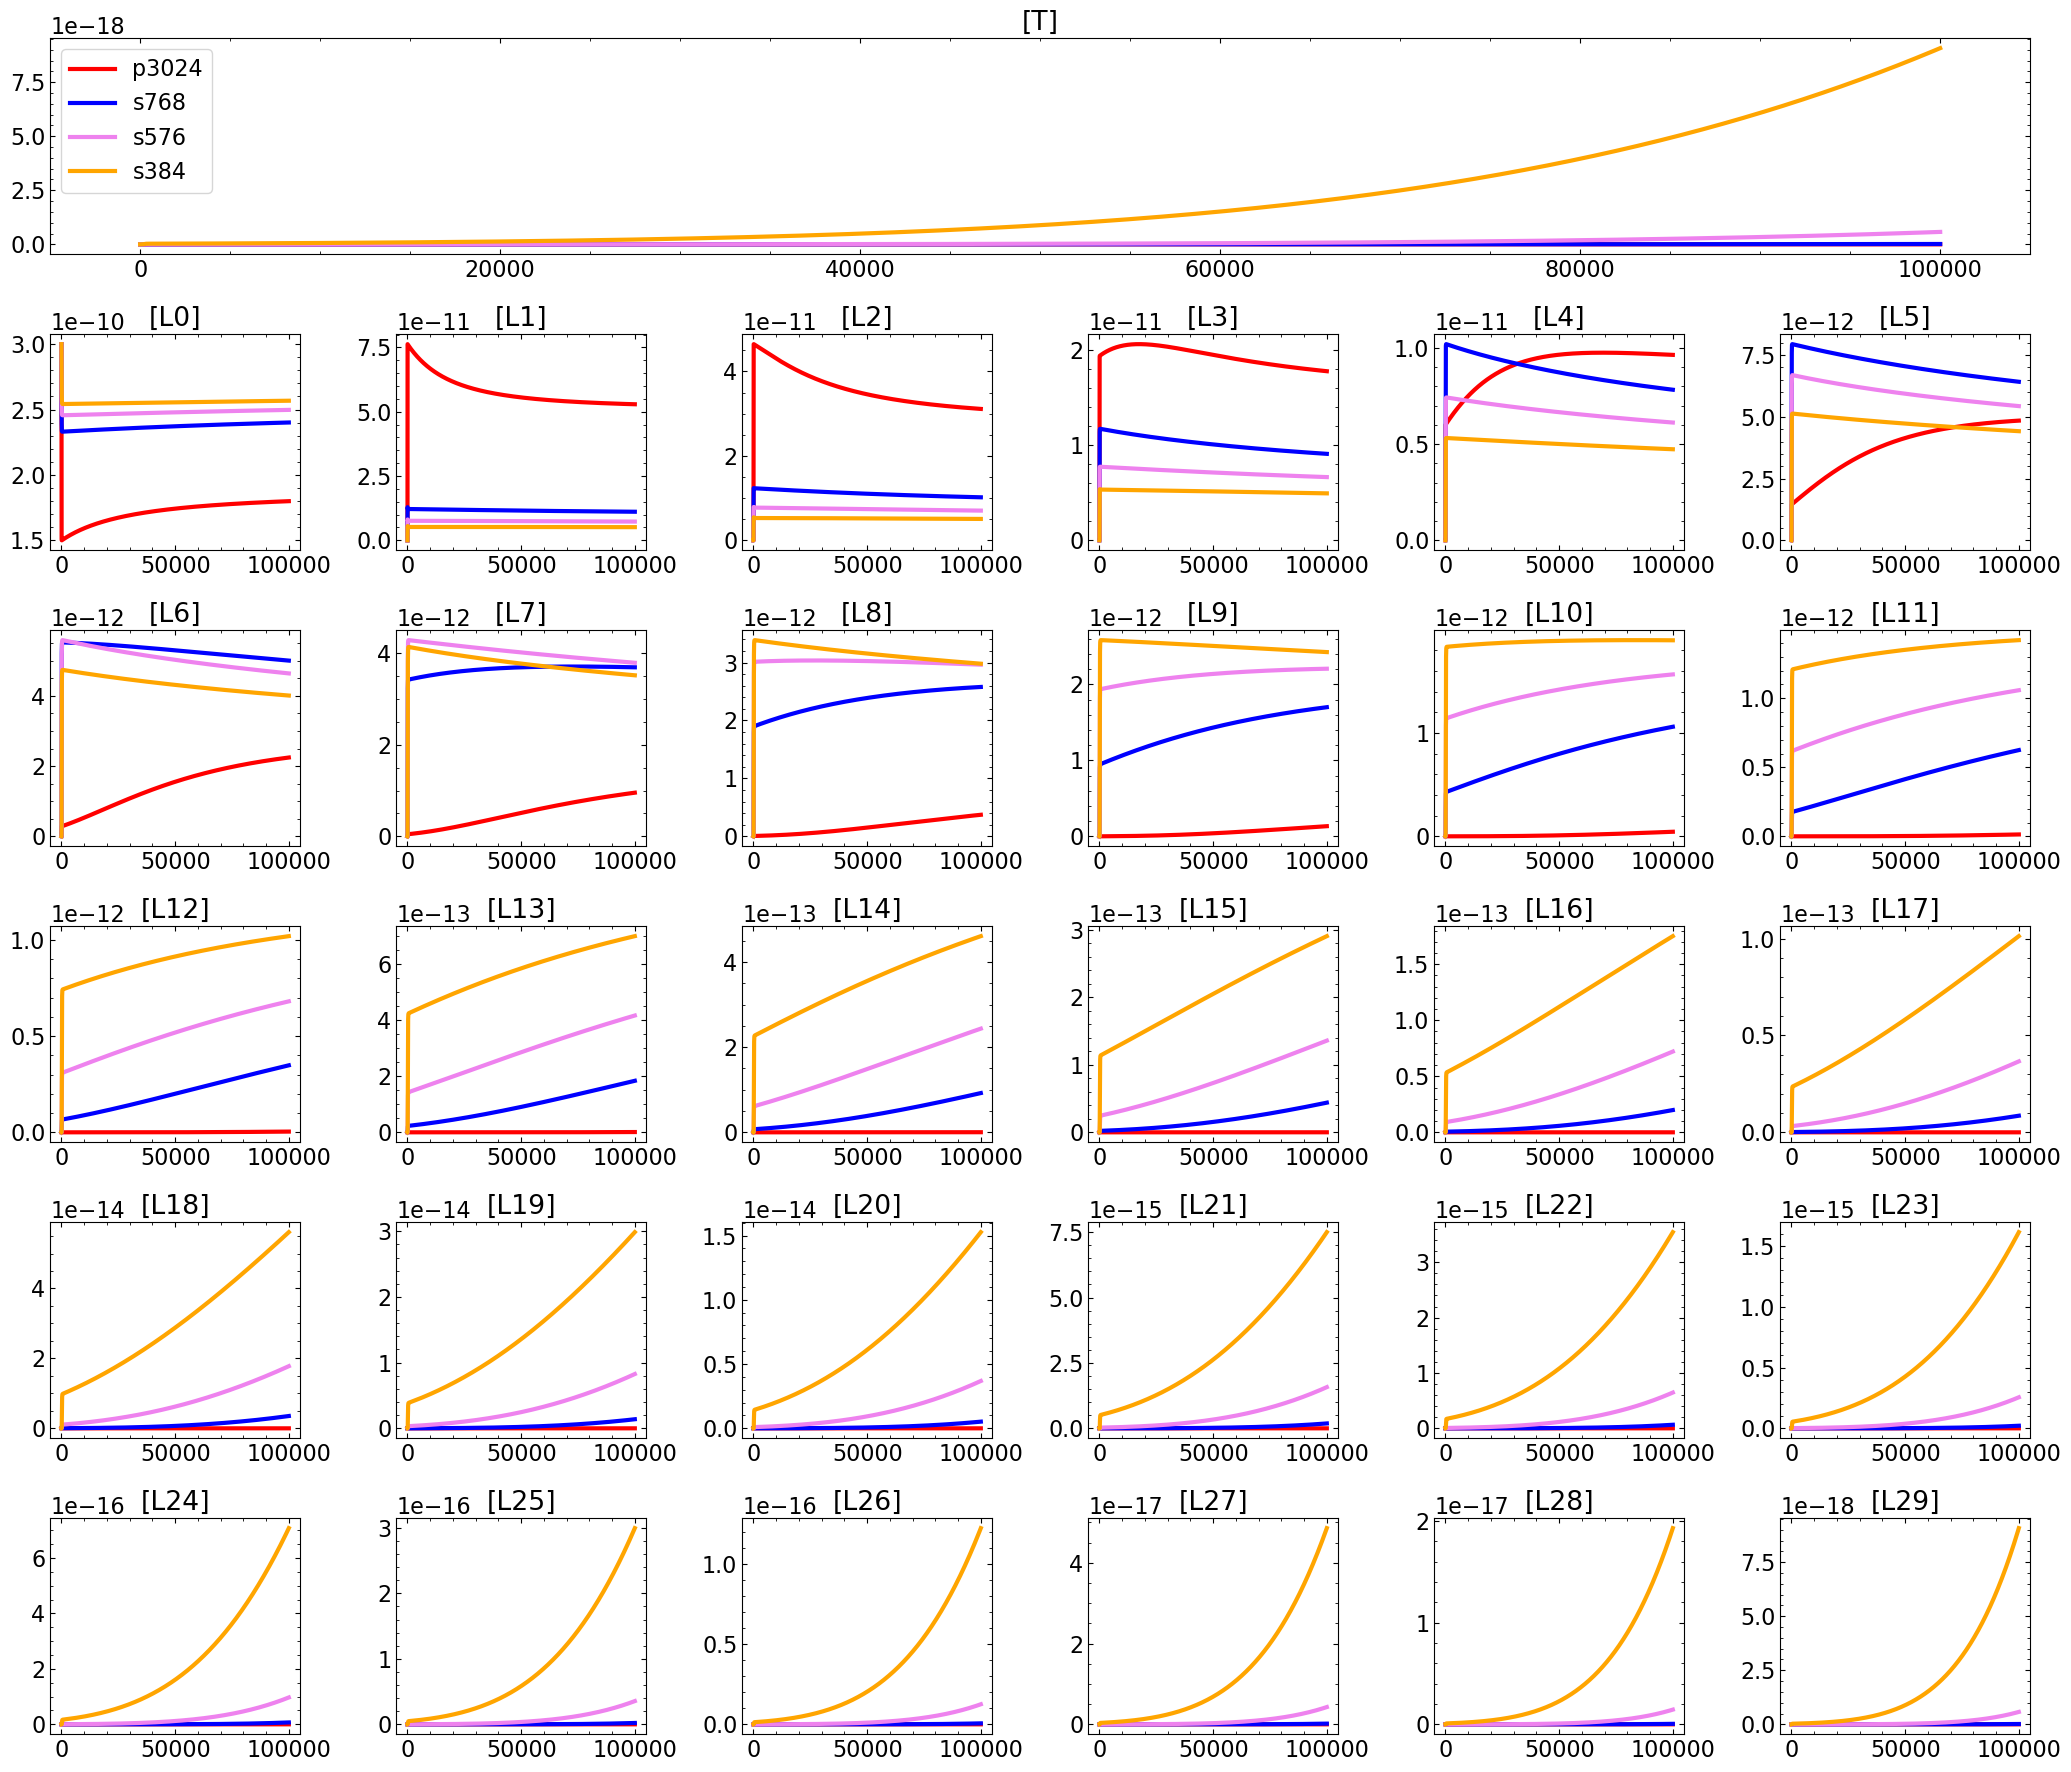

In [20]:
L_mat0s = [L(chain_start[i], N_nucls[i], conts) for i in range(len(seed_len_types))]
plot_time_dependence(L_mat0s, conts)
plt.show()

We then take the last time step of each bin, normalize the resulting model data, and update our $\chi^2$ expression to match.

\begin{align*}
    \chi^2 &= \frac{1}{n_{num}} \sum_{n=1}^{n_{max}} \frac{1}{\sigma_n^2} \left(d_n - \frac{L[t_f, n]}{\int L[t_f,n]}\right)^2
\end{align*}

In [192]:
@jit(target_backend='cuda', nopython = True)
def chi_square(y_data, y_error, model, cont, per_n = False):
    s = 0
    n_num = 0
    for n in range(int(cont[3])):
        if y_error[n] != 0:
            n_num += 1
            s += ((y_data[n] - model[n])/(y_error[n]))**2
    
    if per_n:
        return s/n_num
    else:
        return s
    
def get_error_in_sig_fig(errors_vec):
    sigfigs = []
    for error in errors_vec:
        error_str = f'{error:.2e}' #round to 1 sig fig
        if error_str[0] == '1': #if the first sigfig is a 1
            sigfig = f'{error:.1e}' #round to 2 sig figs
        else:
            sigfig = f'{error:.0e}' #round to 1 sig fig
            if sigfig[0] == '1': #if the first sigfig is a 1 only after rounding up to one sigfig
                sigfig = sigfig.replace('1','1.0')
        sigfigs.append(sigfig)
    return sigfigs

def sign(num_in_scinotation):
    if num_in_scinotation[-3] == '-':
        return -1
    else:
        return 1
    
def get_d(error_str, mean_str): #get the difference in powers between 2 numbers
    extra_error_sig_figs = len(error_str.replace('.','')) - 5 #find the number of extra sig figs in the error
    d = int(mean_str[-1]) * sign(mean_str) - int(error_str[-1]) * sign(error_str) + extra_error_sig_figs
    return d

def get_mean_in_sig_fig(means_vec, errors_vec):
    sigfigs = []
    errors_str_vec = get_error_in_sig_fig(errors_vec)
    means_str_vec = [f'{mean:.2e}' for mean in means_vec]
    for i in range(len(means_vec)):
        if means_vec[i] > errors_vec[i]: #if the mean is larger than the error
            d = get_d(errors_str_vec[i], means_str_vec[i])        
            mean = means_vec[i]
            sigfig = f'{mean:.{d}e}'
        else: #if the error is larger than the mean
            sigfig = f'{means_vec[i]:.0e}'
        sigfigs.append(sigfig)
    return sigfigs
            

def plot_model_results(parrs, y_data_sets, y_error_sets, axs, parr_error = None):
    L_mats = [L(parrs[i], N_nucls[i], conts) for i in range(len(seed_len_types))]
    models = [L_mat[-1,1:int(conts[3]) + 1] / basic_simp(x_data, L_mat[-1,1:int(conts[3]) + 1]) for L_mat in L_mats]
    chi_squares = [chi_square(y_data_sets[i], y_error_sets[i], models[i], conts, per_n=True) for i in range(len(seed_len_types))]
    
    for i in range(len(seed_len_types))[::-1]: #for seed type
        y_axis = [0,0,1,1][i] #determine which quadrant the plot goes in
        x_axis = [0,1,0,1][i]

        axs[y_axis, x_axis].plot(x_data, models[i], color = colors[i], label=seed_len_types[i])
        axs[y_axis, x_axis].set_title(f'$\chi^2 = {chi_squares[i]:.2f}$')
        
        col_labels = ['$k_p$', '$k_{{p0}}$', '$k_d$', '$k_{{break}}$']
        if parr_error == None:
            table_vals = [['%.2e' % j for j in parrs[i]]]
            table = axs[y_axis, x_axis].table(cellText = table_vals, bbox = [0.28,0.4,0.7,0.2], colLabels = col_labels, colWidths= [0.1]*4)
        else:
            table_vals = [get_mean_in_sig_fig(parrs[i], parr_error[i]),
                          [f'$\pm${error}' for error in get_error_in_sig_fig(parr_error[i])]]
                          
            #table_vals = [['%.2e' % j for j in parrs[i]],
            #             [ '$\pm$%.1g' % k for k in parr_error[i]]]
            table = axs[y_axis, x_axis].table(cellText = table_vals, bbox = [0.28,0.32,0.7,0.4], colLabels = col_labels, colWidths= [0.1]*4)

         
        table.auto_set_font_size(False)
        table.set_fontsize(18)
        
        axs[y_axis, x_axis].legend(prop={'size': 20}, frameon=False)

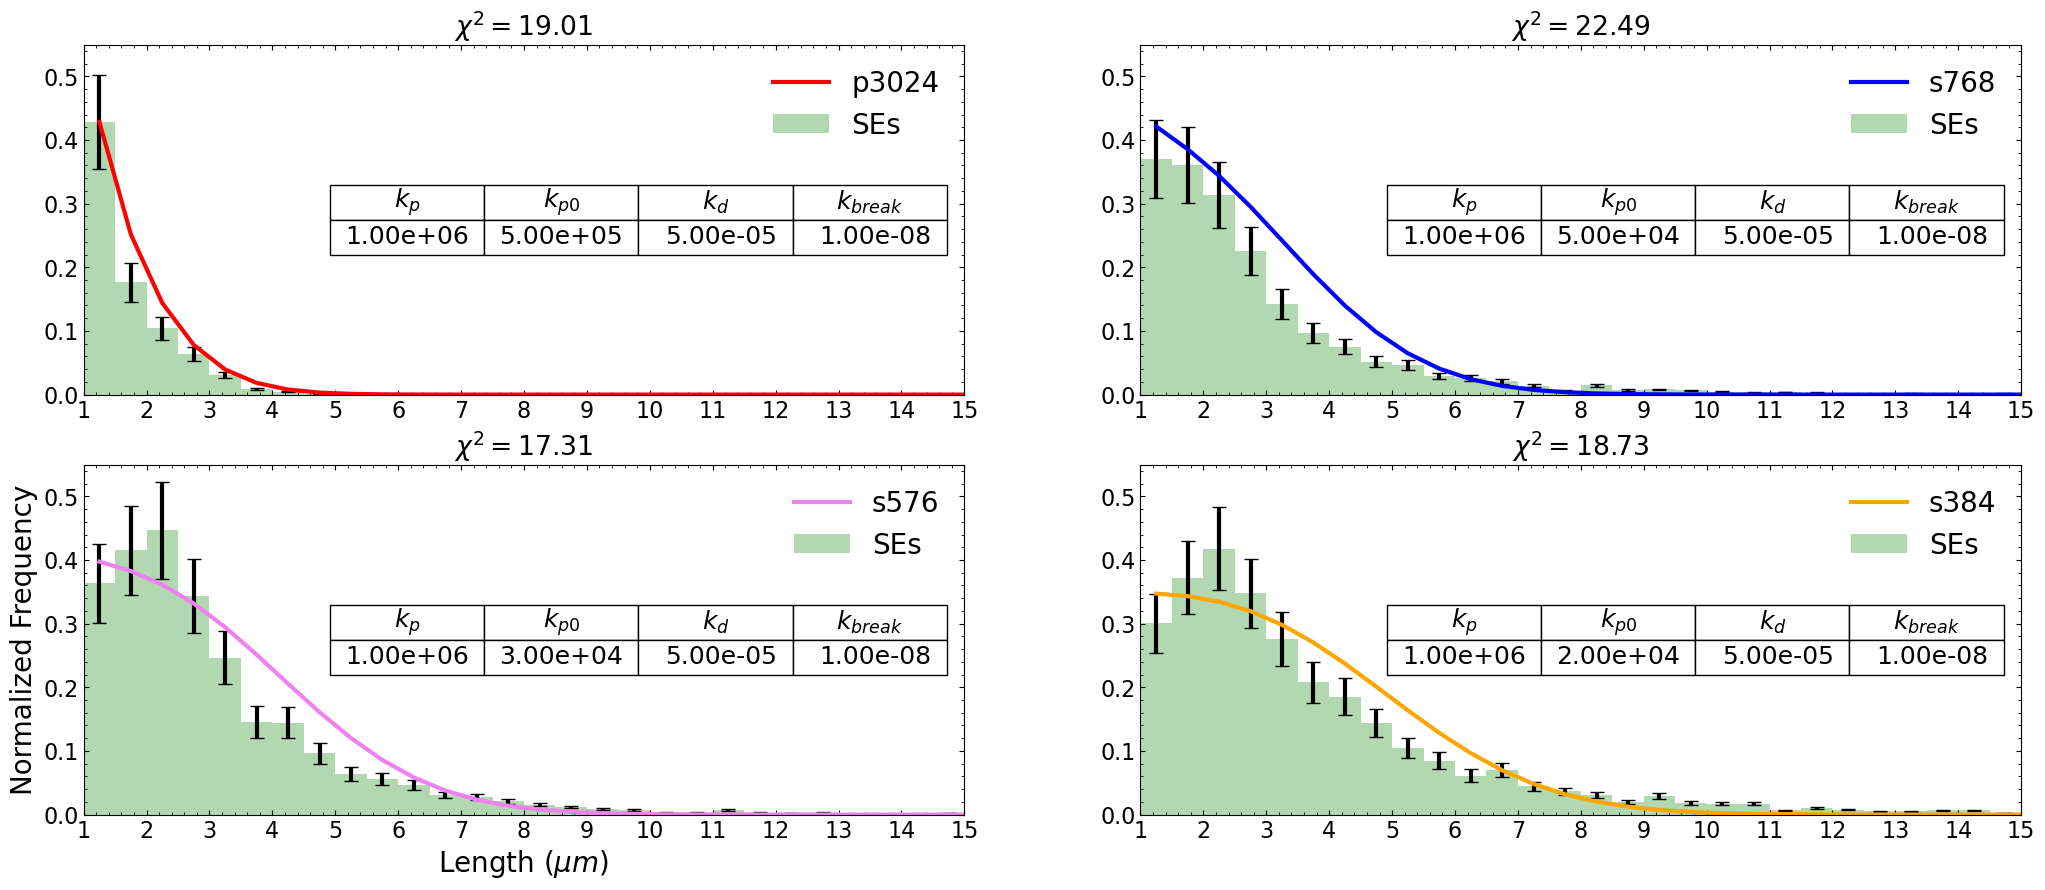

In [184]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
plot_hist(y_data_sets, y_error_sets, axs)
plot_model_results([chain_start[i] for i in range(len(seed_len_types))], y_data_sets, y_error_sets, axs)
plt.show()

Referencing how we estimate the area under the curve above we have

\begin{align*}
    \int L[t_f, n] &= \frac{x_{data}[-1] - x_{data}[0]}{6} \left[ L[t_f, 1] + 4L\left[ t_f, \frac{1 + n_{max}}{2} \right] + L[t_f, n_{max}] \right] \\
    \chi^2 &= \frac{1}{n_{num}} \sum_{n=1}^{n_{max}} \frac{1}{\sigma_n^2} \left(d_n - \frac{6}{x_{data}[-1] - x_{data}[0]} \frac{L[t_f,n]}{L[t_f, 1] + 4L\left[ t_f, \frac{1 + n_{max}}{2} \right] + L[t_f, n_{max}]} \right)^2
\end{align*}

In [23]:
#printing the above expression for each example to verify this is equivalent to chi square as shown above
for i in range(len(seed_len_types)):
    test_L_vec = L_mat0s[i][-1,:]
    sum = 0
    n_num = 0
    for n in range(1,int(conts[3]) + 1):
        if y_error_sets[i][n -1] != 0:
            n_num += 1
            term1 = y_data_sets[i][n-1]
            term2 = 6/(x_data[-1] - x_data[0])
            term3 = (test_L_vec[n])/(test_L_vec[1] + 4 * test_L_vec[int((1 + int(conts[3]))/2)] + test_L_vec[int(conts[3])])
            sum += ((term1 - term2*term3) / (y_error_sets[i][n-1]))**2
    print(sum/n_num)

18.22295509037727
22.698832351644743
17.61611330969674
19.034074971249012


In order to minimize the $\chi^2$ we need to be able to take a derivative with respect to the fit parameters which we can only do if we express everything in terms of dL instead of L. To do this we will plug in the eurler approximation for each L (remembering that $L[t_0,n]=0$ for $1\leq n \leq n_{max}$)

lets define $\gamma_n$ and $\psi$

\begin{align*}
    \gamma_n &= \frac{6}{x_{data}[-1] - x_{data}[0]} \frac{L[t_f,n]}{L[t_f, 1] + 4L\left[ t_f, \frac{1 + n_{max}}{2} \right] + L[t_f, n_{max}]} \\
    \gamma_n &= \frac{6}{x_{data}[-1] - x_{data}[0]} \frac{h \sum_{t=0}^{t_f-1} \frac{dL[t,n]}{dt}}{h \sum_{t=0}^{t_f-1} \frac{dL[t,1]}{dt} + 4h \sum_{t=0}^{t_f-1} \frac{dL\left[t,\frac{1 + n_{max}}{2}\right]}{dt} + h \sum_{t=0}^{t_f-1} \frac{dL[t,n_{max}]}{dt}} \\
    \gamma_n &= \frac{6}{x_{data}[-1] - x_{data}[0]} \frac{h \sum_{t=0}^{t_f-1} \frac{dL[t,n]}{dt}}{h \sum_{t=0}^{t_f-1} \left( \frac{dL[t,1]}{dt} + 4 \frac{dL\left[t,\frac{1 + n_{max}}{2}\right]}{dt} + \frac{dL[t,n_{max}]}{dt} \right)} \\
    \psi &= \sum_{t=0}^{t_f-1}\left(\frac{dL[t,1]}{dt}+ 4  \frac{dL\left[t,\frac{1 + n_{max}}{2}\right]}{dt} + \frac{dL[t,n_{max}]}{dt}\right) \\
    \gamma_n &= \frac{6}{x_{data}[-1] - x_{data}[0]} \left(\sum_{t=0}^{t_f-1} \frac{dL[t,n]}{dt}\right) ( \psi)^{-1} \\
    \chi^2 &= \frac{1}{n_{num}} \sum_{n=1}^{n_{max}} \frac{1}{\sigma_n^2} (dn - \gamma_n)^2 
\end{align*}

In [24]:
@njit
def get_dL_mat(L_mat, parr, N_nucl, cont):
    dL_mat = np.zeros((int(cont[5]), int(cont[3]) + 2))
    for t in range(0, int(cont[5])):
        dL_mat[t,:] = dL(L_mat[t,:], parr, N_nucl, cont)
    return dL_mat

lets check that my method of representing L in terms of dL holds

In [25]:
dL_mat0s = [get_dL_mat(L_mat0s[i], chain_start[i], N_nucls[i], conts) for i in range(len(seed_len_types))]
print(L_mat0s[0][-1, 4])
print(conts[6]*np.sum(dL_mat0s[0][:int(conts[5])-1,4]))

9.63298157818646e-12
9.632981578186282e-12


In [26]:
psi = njit(lambda dL_mat, cont : np.sum(dL_mat[:int(cont[5]), 1] + 4 * dL_mat[:int(cont[5]), int((1 + int(cont[3]))/2)] + dL_mat[:int(cont[5]), int(cont[3])])) 
@njit
def get_gamma_vec(dL_mat, cont):
    gamma_vec = np.zeros(int(cont[3]) + 2)
    for n in range(int(cont[3]) + 2):
        coef = 6/(x_data[-1] - x_data[0])
        gamma_vec[n] = coef * np.sum(dL_mat[:int(cont[5])-1, n]) / psi(dL_mat, cont)
    return gamma_vec

In [27]:
#printing the above expression for each example to verify again this is still equivalent to chi square
for i in range(len(seed_len_types)):
    gamma = get_gamma_vec(dL_mat0s[i], conts)
    sum = 0
    n_num = 0
    for n in range(1,int(conts[3]) +  1):
        if y_error_sets[i][n-1] != 0:
            n_num += 1
            term1 = y_data_sets[i][n-1]
            term2 = gamma[n]
            sum += ((term1 - term2) / (y_error_sets[i][n-1]))**2
    print(sum/n_num)

18.222979380467187
22.698839452129253
17.616110114287455
19.03406828021971


Next we need to take the derivative of $\chi^2$ with respect to each fit parameter so we can solve the system of equations 
\begin{align*}
    \frac{\partial \chi^2}{\partial k_p} = \frac{\partial \chi^2}{\partial k_{p_0}} = \frac{\partial \chi^2}{\partial k_d} = \frac{\partial \chi^2}{\partial k_{break}} = 0
\end{align*}

\begin{align*}
    \frac{\partial \chi^2}{\partial p} &= \frac{-2}{n_{num}} \sum_{n=1}^{29} \frac{1}{\sigma_n^2} (d_n - \gamma_n) \frac{\partial \gamma_n}{\partial p}  \\
    \frac{\partial \gamma_n}{\partial p} &= \frac{6}{x_{data}[-1] - x_{data}[0]} \left[\frac{\partial}{\partial p} \left( \sum_{t=0}^{t_f -1} \frac{dL[t,n]}{dt} \right) ( \psi )^{-1} + \sum_{t=0}^{t_f -1} \frac{dL[t,n]}{dt} \frac{\partial}{\partial p} ((\psi)^{-1}) \right] \\
    \frac{\partial \gamma_n}{\partial p} &= \frac{6}{x_{data}[-1] - x_{data}[0]} \left[ \left( \sum_{t=0}^{t_f -1} \frac{\partial}{\partial p} \frac{dL[t,n]}{dt} \right) ( \psi )^{-1} - \left( \sum_{t=0}^{t_f -1} \frac{dL[t,n]}{dt} \right) (  \psi )^{-2} \left( \frac{\partial \psi}{\partial p} \right) \right] \\
    \frac{\partial \psi}{\partial p} &= \sum_{t=0}^{t_f-1} \left( \frac{\partial}{\partial p} \frac{dL[t,1]}{dt} + 4 \frac{\partial}{\partial p} \frac{dL\left[t,\frac{1 + n_{max}}{2}\right]}{dt} + \frac{\partial}{\partial p} \frac{dL[t,n_{max}]}{dt}\right)
\end{align*}

Where we have already found $\frac{\partial}{\partial p} \frac{dL[t,n]}{dt}$ for every parameter!

In [28]:
@njit
def part_psi(L_mat, N_nucl, par_div, cont):
    x = 0
    for L_vec in L_mat[:int(cont[5])-1, :]: #sum over time
        x += part_dL(L_vec, 1, N_nucl, par_div, cont) + 4 * part_dL(L_vec, int((1 + int(cont[3]))/2), N_nucl, par_div, cont) + part_dL(L_vec, int(cont[3]), N_nucl, par_div, cont)
    return x

@njit
def get_part_gamma_vec(dL_mat, L_mat, N_nucl, par_div, cont):
    part_gamma_vec = np.zeros(int(cont[3]) + 2)
    psi_term = psi(dL_mat, cont)
    part_psi_term = part_psi(L_mat, N_nucl, par_div, cont)

    for n in range(int(cont[3]) + 2):
        sum_part_L_term = 0
        for L_vec in L_mat[:int(cont[5])-1, :]: #sum over time
            sum_part_L_term += part_dL(L_vec, n, N_nucl, par_div, cont)
        
        term1 = sum_part_L_term / psi_term
        term2 = np.sum(dL_mat[:int(cont[5]) - 1,n]) * part_psi_term / (psi_term**2)
        part_gamma_vec[n] = (6/(x_data[-1] - x_data[0])) * (term1 - term2)

    return part_gamma_vec

@njit
def part_chi(parr, N_nucl, y_data, y_error, par_div, cont):
    L_mat = L(parr, N_nucl, cont)
    dL_mat = get_dL_mat(L_mat, parr, N_nucl, cont)
    gamma_vec = get_gamma_vec(dL_mat, cont)
    part_gamma_vec = get_part_gamma_vec(dL_mat, L_mat, N_nucl, par_div, cont)

    part_chi_square = 0
    n_num = 0

    for n in range(1,int(cont[3]) + 1):
        if y_error[n-1] != 0:
            n_num += 1
            part_chi_square += ((y_data[n-1] - gamma_vec[n])/(y_error[n-1]**2)) * part_gamma_vec[n]

    return -2 * part_chi_square /n_num

In [29]:
@njit
def equations(parr, N_nucl, y_data, y_error, cont):
    return (part_chi(parr, N_nucl, y_data, y_error, 'kp', cont),
            part_chi(parr, N_nucl, y_data, y_error, 'kp0', cont),
            part_chi(parr, N_nucl, y_data, y_error, 'kd', cont),
            part_chi(parr, N_nucl, y_data, y_error, 'kbreak', cont))

#bounds = ((10,10,10**(-8),0),(10**7, 10**7, 10**4, 10**2))
bounds = ((10,10,10**(-7),10**-10),(10**7, 10**7, 10**-2, 10**-5))

Before we can actually do this equation solve, we need to pick an initial guess. It turns out the posterior of this distribution is very messing and there are a lot of local minimums this could get stuck in. So we will use a Monte Chain Monte Carlo to get near the global minimum (within the bounds) so that when the least_squares finds the nearest zero point, it should converge on the global minimum.

To do this we need log of the likelihood:

\begin{align*}
    \ln(\mathcal{L}) = -\frac{1}{2} \chi^2
\end{align*}

In [30]:
#@jit(target_backend='cuda', nopython = False, forceobj=True)
def get_log_like(parr, y_data_set, y_error_set, N_nucl, conts, bounds):
    for i in range(len(parr)):
        if not (bounds[0][i] < parr[i] < bounds[1][i]):
            return -np.inf #return an infanitly small likelhood if any of the parameters out outside the bounds

    L_mat = L(parr, N_nucl, conts)
    model = L_mat[-1,1:int(conts[3]) + 1] / basic_simp(x_data, L_mat[-1,1:int(conts[3]) + 1])

    chi = chi_square(y_data_set, y_error_set, model, conts, per_n = False)

    return -0.5 * (chi)**2

In [31]:
def plot_chain_results(sampler):
    chain = sampler.get_chain(flat = True)
    log_like_chain = sampler.get_log_prob(flat = True)
    steps = np.arange(np.shape(chain)[0])
    fig, axs = plt.subplots(5, figsize=(10,18))


    for i in range(4):
        axs[i].plot(steps, chain[:,i])
        axs[i].set_title(['kp', 'kp0', 'kd', 'kbreak'][i])
        axs[4].plot(steps, log_like_chain)
        axs[4].set_title('Log Like')

    plt.show()  

    fig = corner.corner(chain, labels = ['kp','kp0','kd','kbreak'])
    plt.show()

In [33]:
#hyperparameters
nwalkers = 12
ndim = 4 #since we have 4 parameters

#starting position
sigma_guess = np.array([1e4, 1e4, 1e-7, 1e-9], dtype=np.float64)

#@jit(target_backend='cuda', nopython = False, forceobj=True)
def run_mcmc(n_MCMC, y_data, y_error, chain_start, N_nucl, conts, bounds):
    p0 = np.random.randn(nwalkers, ndim)*sigma_guess + chain_start
    sampler = emcee.EnsembleSampler(nwalkers, ndim, get_log_like, args = (y_data, y_error, N_nucl, conts, bounds))
    sampler.run_mcmc(p0, n_MCMC, progress = True);

    print(sampler.acceptance_fraction) 
    return sampler

In [ ]:
sampler = run_mcmc(10000, y_data_sets[0], y_error_sets[0], chain_start[0], N_nucls[0], conts, bounds) 
best_guess = sampler.get_chain(flat = True)[np.argmax(sampler.flatlnprobability)]

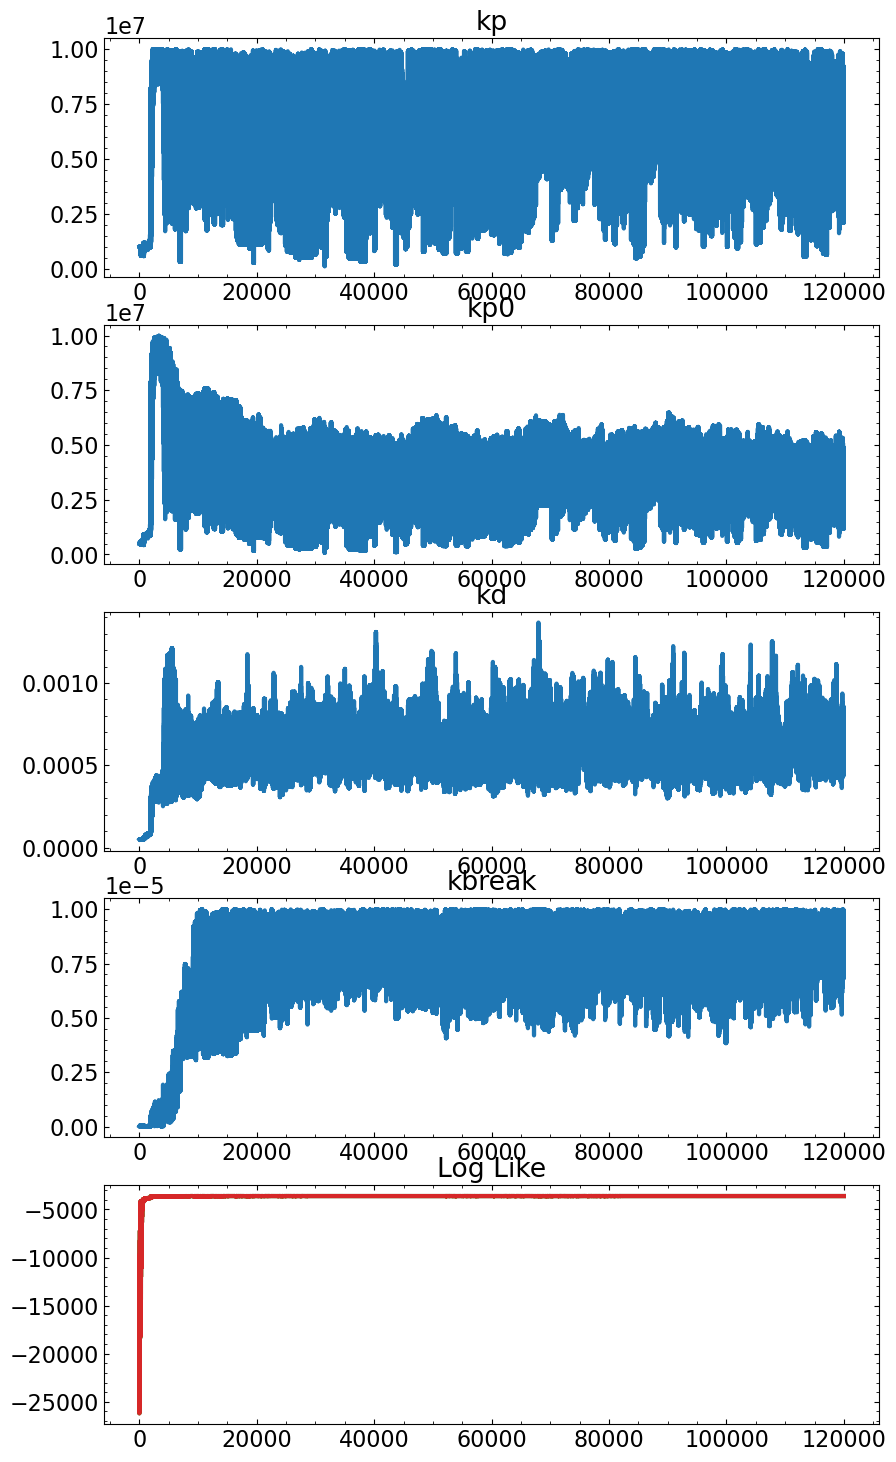

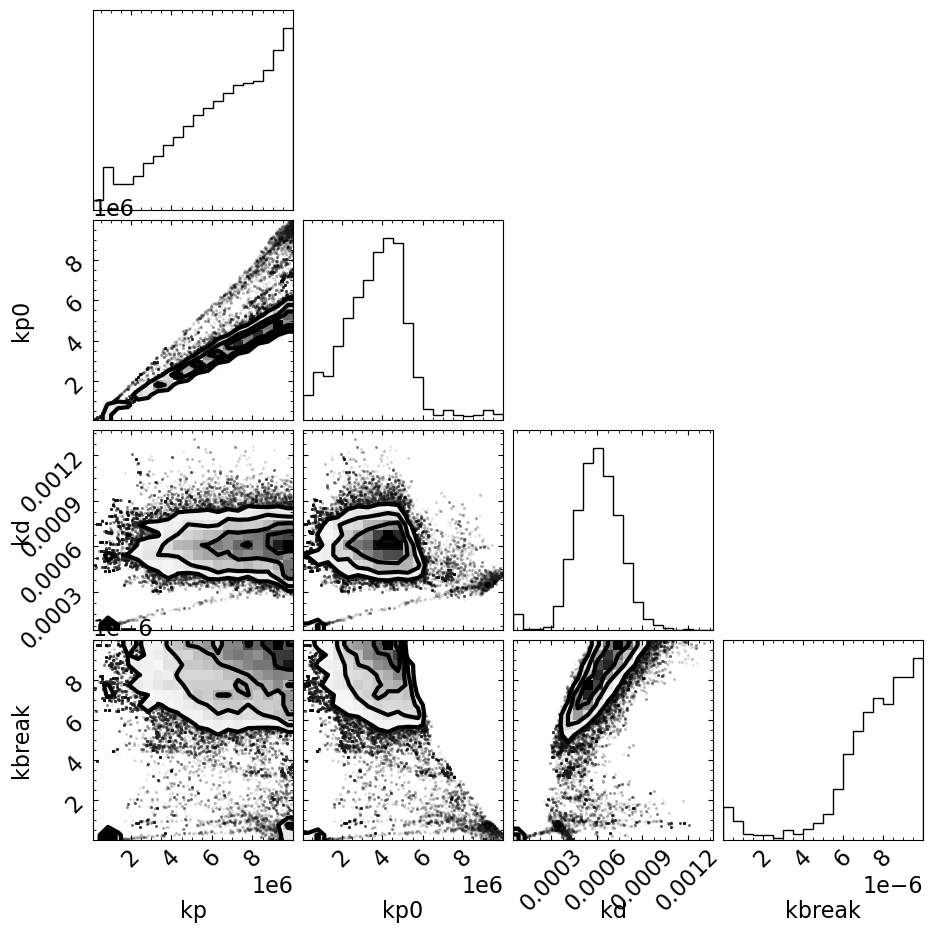

In [34]:
plot_chain_results(sampler)

In [35]:
print(best_guess)

[6.82074568e+06 3.34941880e+06 7.18725902e-04 9.65279385e-06]


In [185]:
conts[5] = 500000.0
conts[6] = conts[4]/conts[5] #h

#parr0s = [[8.7e+06, 4.2e+06, 7.2e-04, 9.7e-06],
#    [8.7e+06, 4.0e+05, 7.2e-04, 9.7e-06],
#    [8.7e+06, 1.0e+05, 7.2e-04, 9.7e-06],
#    [8.7e+06, 8.0e+04, 7.2e-04, 9.7e-06]]

parr0s = [[6.8e+06, 3.3e+06, 7.2e-04, 9.7e-06],
    [6.8e+06, 3.0e+05, 7.2e-04, 9.7e-06],
    [6.8e+06, 1.0e+05, 7.2e-04, 9.7e-06],
    [6.8e+06, 8.0e+04, 7.2e-04, 9.7e-06]]

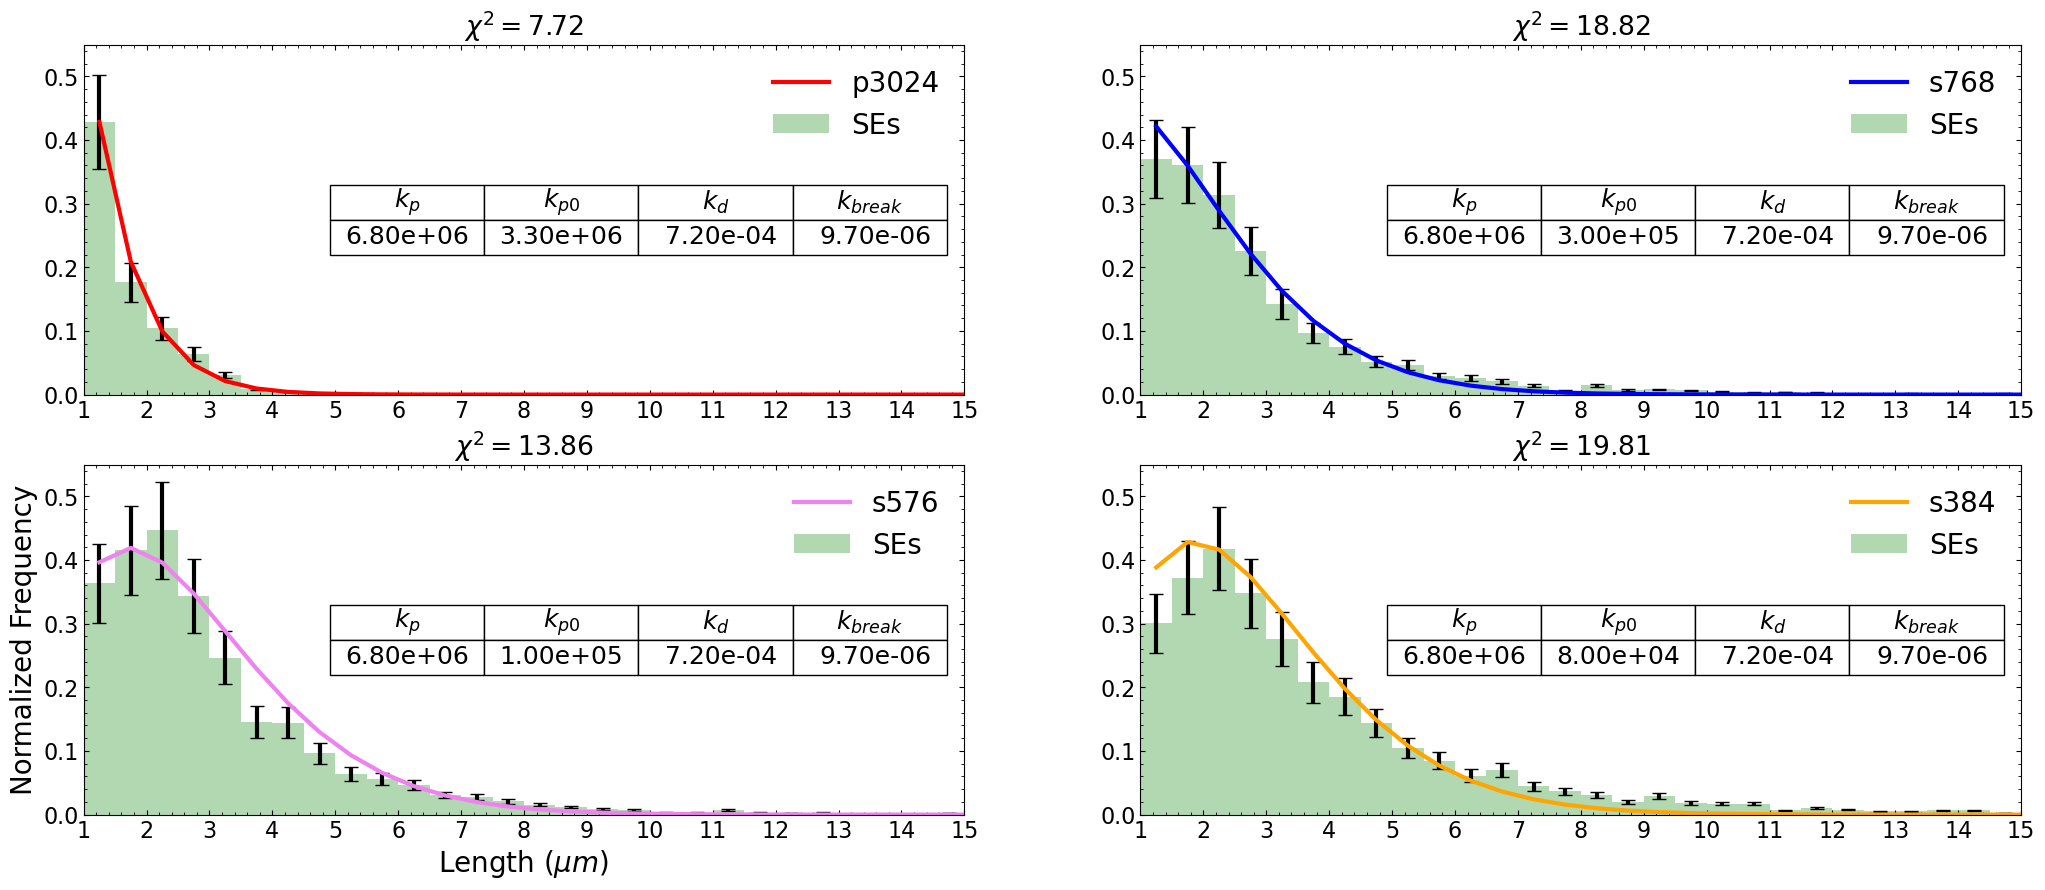

In [186]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
plot_hist(y_data_sets, y_error_sets, axs)
plot_model_results([parr0s[i] for i in range(len(seed_len_types))], y_data_sets, y_error_sets, axs)
plt.show()

In [34]:
def save_fit_results(parrs, names):
    fit_results = open_json('fit_results.json')
    for i in range(len(parrs)):
        fit_results[names[i]] = {'par' : list(parrs[i]), 'error' : []}
    write_json(fit_results, 'fit_results.json')

def save_fit_errors(errors, names):
    fit_results = open_json('fit_results.json')
    for i in range(len(errors)):
        seed_data = fit_results[names[i]]
        seed_data['error'] = list(errors[i])
        fit_results[names[i]] = seed_data
    write_json(fit_results, 'fit_results.json')

In [35]:
fit_results = Parallel(n_jobs=4, verbose=10)(delayed(least_squares)(equations, parr0s[i], bounds = bounds, args=(N_nucls[i], y_data_sets[i], y_error_sets[i], conts)) for i in range(len(seed_len_types)))
save_fit_results([fit_results[i].x for i in range(4)], seed_len_types)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  5.1min remaining:  5.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.1min finished


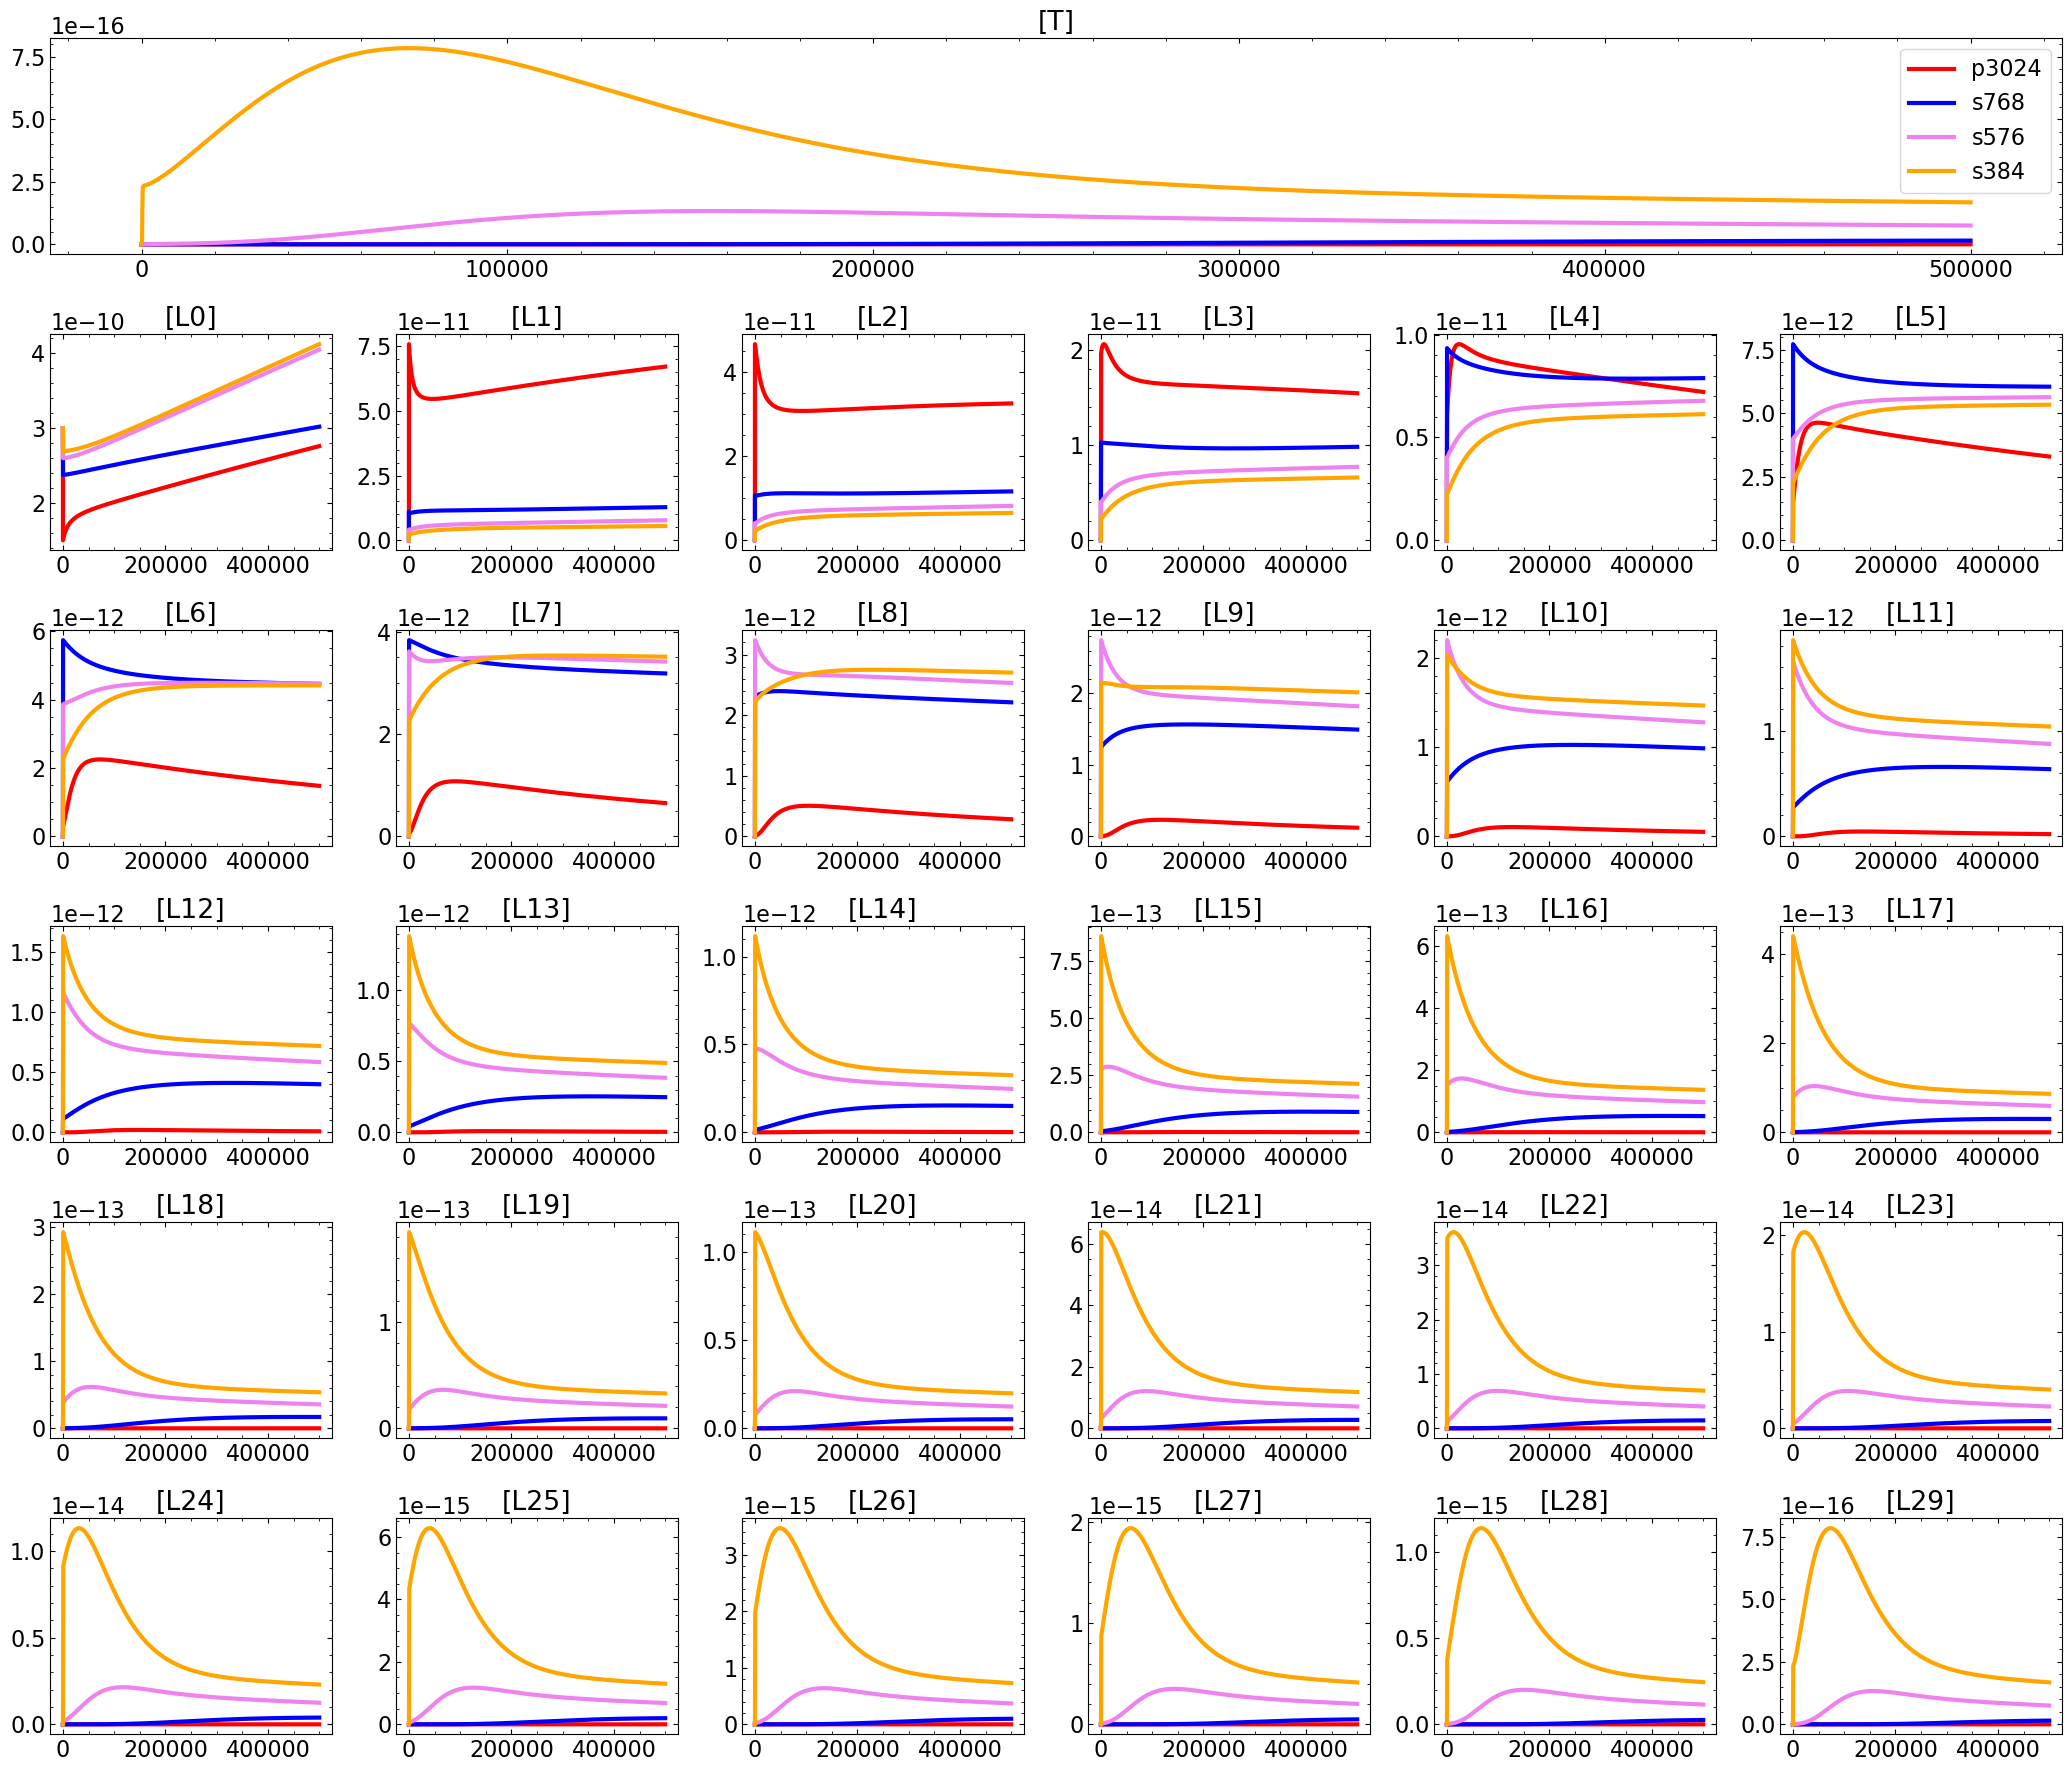

In [36]:
plot_time_dependence([L(fit_results[i].x, N_nucls[i], conts) for i in range(len(seed_len_types))], conts)
plt.show()

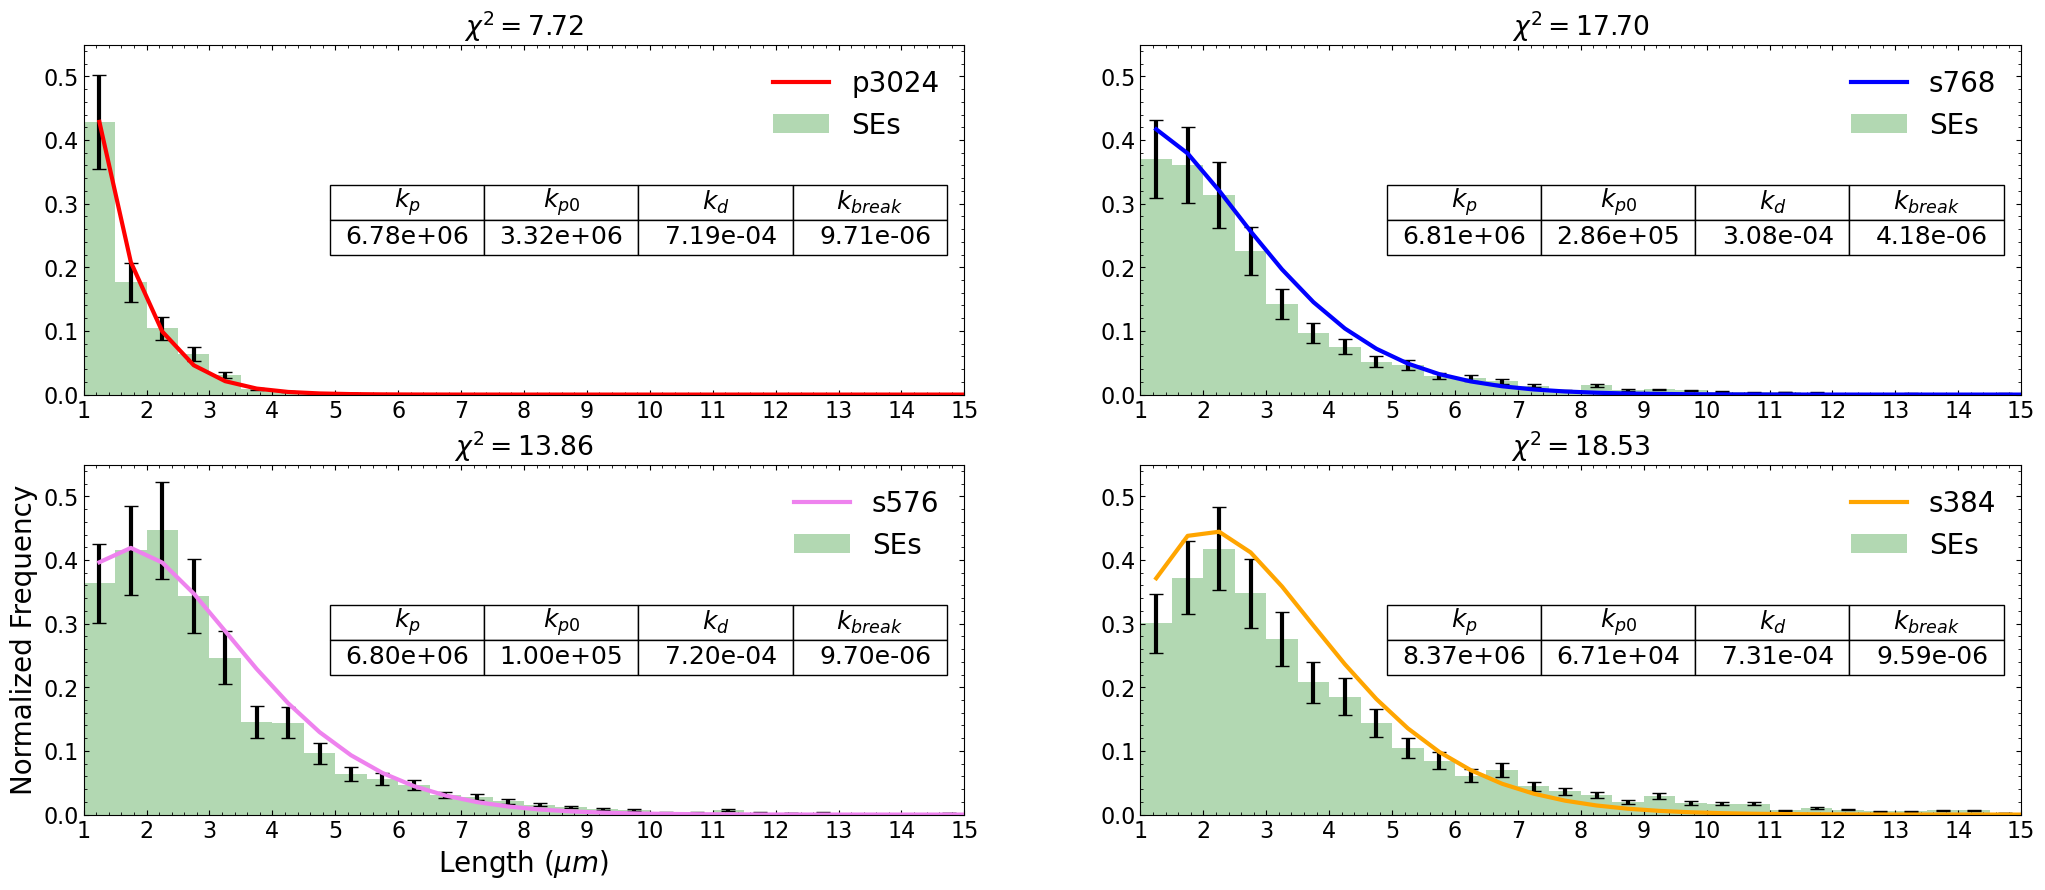

In [187]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
plot_hist(y_data_sets, y_error_sets, axs)
plot_model_results([fit_results[i].x for i in range(4)], y_data_sets, y_error_sets, axs)
plt.show()

We want to find an error for each of these fit values, to do this we will bootstrap each of our data sets x times. And find a distribution of fit parameters which will allow us to report a sigma for the parameter.

In [38]:
def bootstrap_data(len_dist):
    new_len_dist = []
    for _ in range(len(len_dist)):
        new_len_dist.append(random.choice(len_dist))
    return new_len_dist

def get_boot_fit(len_dist, parr0, bounds, N_nucl, conts):
    boot_len_dist = bootstrap_data(len_dist)
    y_data = get_ydata(boot_len_dist)
    y_error = get_yerror(boot_len_dist)
    try:
        fit_result = least_squares(equations, parr0, bounds = bounds, args = (N_nucl, y_data, y_error, conts))
    except:
        return None, y_data, y_error
    
    return fit_result.x, y_data, y_error

In [39]:
num_boot = 10
bootstrap_results = Parallel(n_jobs= -1, verbose=10)(delayed(get_boot_fit)(len_dists[i], parr0s[i], bounds, N_nucls[i], conts) for i in range(4) for _ in range(num_boot)) #order in this array is p3024_set1, p3024_set2, ..., p3024_set_num_boot, s768set_1, etc....

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done   2 out of  40 | elapsed: 10.7min remaining: 203.3min
[Parallel(n_jobs=-1)]: Done   7 out of  40 | elapsed: 13.2min remaining: 62.3min
[Parallel(n_jobs=-1)]: Done  12 out of  40 | elapsed: 14.2min remaining: 33.0min
[Parallel(n_jobs=-1)]: Done  17 out of  40 | elapsed: 15.4min remaining: 20.8min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed: 16.5min remaining: 13.5min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed: 17.3min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 22.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed: 26.0min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 28.3min finished


In [42]:
def plot_bootstrap_results(bootstrap_results, num_boot, conts, c = 'g'):
    fig, axs = plt.subplots(num_boot, 4, figsize = (25,5*num_boot))
    means = []
    sigmas = []

    if len(bootstrap_results[0][1])==29:
        width = 0.5
    else:
        width = 1.25

    for i in range(4):
        fit_kp, fit_kp0, fit_kd, fit_kbreak = [], [], [], []
        for n in range(num_boot):
            fit, y_data, y_error = bootstrap_results[n + i*num_boot]
            axs[n, i].bar(x_data, y_data, alpha = 0.3, label = 'SEs', color = c, yerr = y_error, width = width, capsize = 5)
            axs[n, i].set_xlim(1,15)
            axs[n, i].set_ylim(0,0.9)
            axs[n, i].set_xticks(np.arange(1, 16, step = 1), np.arange(1, 16, step = 1))

            if type(fit) != type(None):
                fit_kp.append(fit[0])
                fit_kp0.append(fit[1])
                fit_kd.append(fit[2])
                fit_kbreak.append(fit[3])

                L_mat = L(fit, N_nucls[i], conts)
                model = L_mat[-1,1:int(conts[3]) + 1] / basic_simp(x_data, L_mat[-1,1:int(conts[3]) + 1])
                chi_sq = chi_square(y_data, y_error, model, conts)

                axs[n, i].plot(x_data, model, color = colors[i], label=seed_len_types[i])
                axs[n, i].set_title(f'$\chi^2 = {chi_sq:.2f}$, $kp0 = {fit[1]:.2f}$')
                #axs[n, i].legend(prop={'size': 25}, frameon=False)

        print(f'{seed_len_types[i]} kp: {np.mean(fit_kp):.2e} +- {np.std(fit_kp):.2e} kp0: {np.mean(fit_kp0):.2e} +- {np.std(fit_kp0):.2e} kd: {np.mean(fit_kd):.2e} +- {np.std(fit_kd):.2e} kbreak: {np.mean(fit_kbreak):.2e} +- {np.std(fit_kbreak):.2e}')
        means.append([np.mean(fit_kp), np.mean(fit_kp0), np.mean(fit_kd), np.mean(fit_kbreak)])
        sigmas.append([np.std(fit_kp), np.std(fit_kp0), np.std(fit_kd), np.std(fit_kbreak)])

    return means, sigmas

p3024 kp: 4.72e+06 +- 9.88e+05 kp0: 5.31e+06 +- 9.00e+05 kd: 2.43e-03 +- 3.78e-03 kbreak: 9.29e-06 +- 1.53e-06
s768 kp: 6.63e+06 +- 1.28e+05 kp0: 5.45e+05 +- 1.83e+05 kd: 7.12e-04 +- 2.54e-05 kbreak: 9.74e-06 +- 4.70e-08
s576 kp: 6.77e+06 +- 3.14e+04 kp0: 1.51e+05 +- 4.56e+04 kd: 7.31e-04 +- 3.20e-05 kbreak: 9.75e-06 +- 1.16e-07
s384 kp: 6.83e+06 +- 1.21e+05 kp0: 1.18e+05 +- 5.19e+04 kd: 8.87e-04 +- 3.04e-04 kbreak: 9.61e-06 +- 3.50e-07


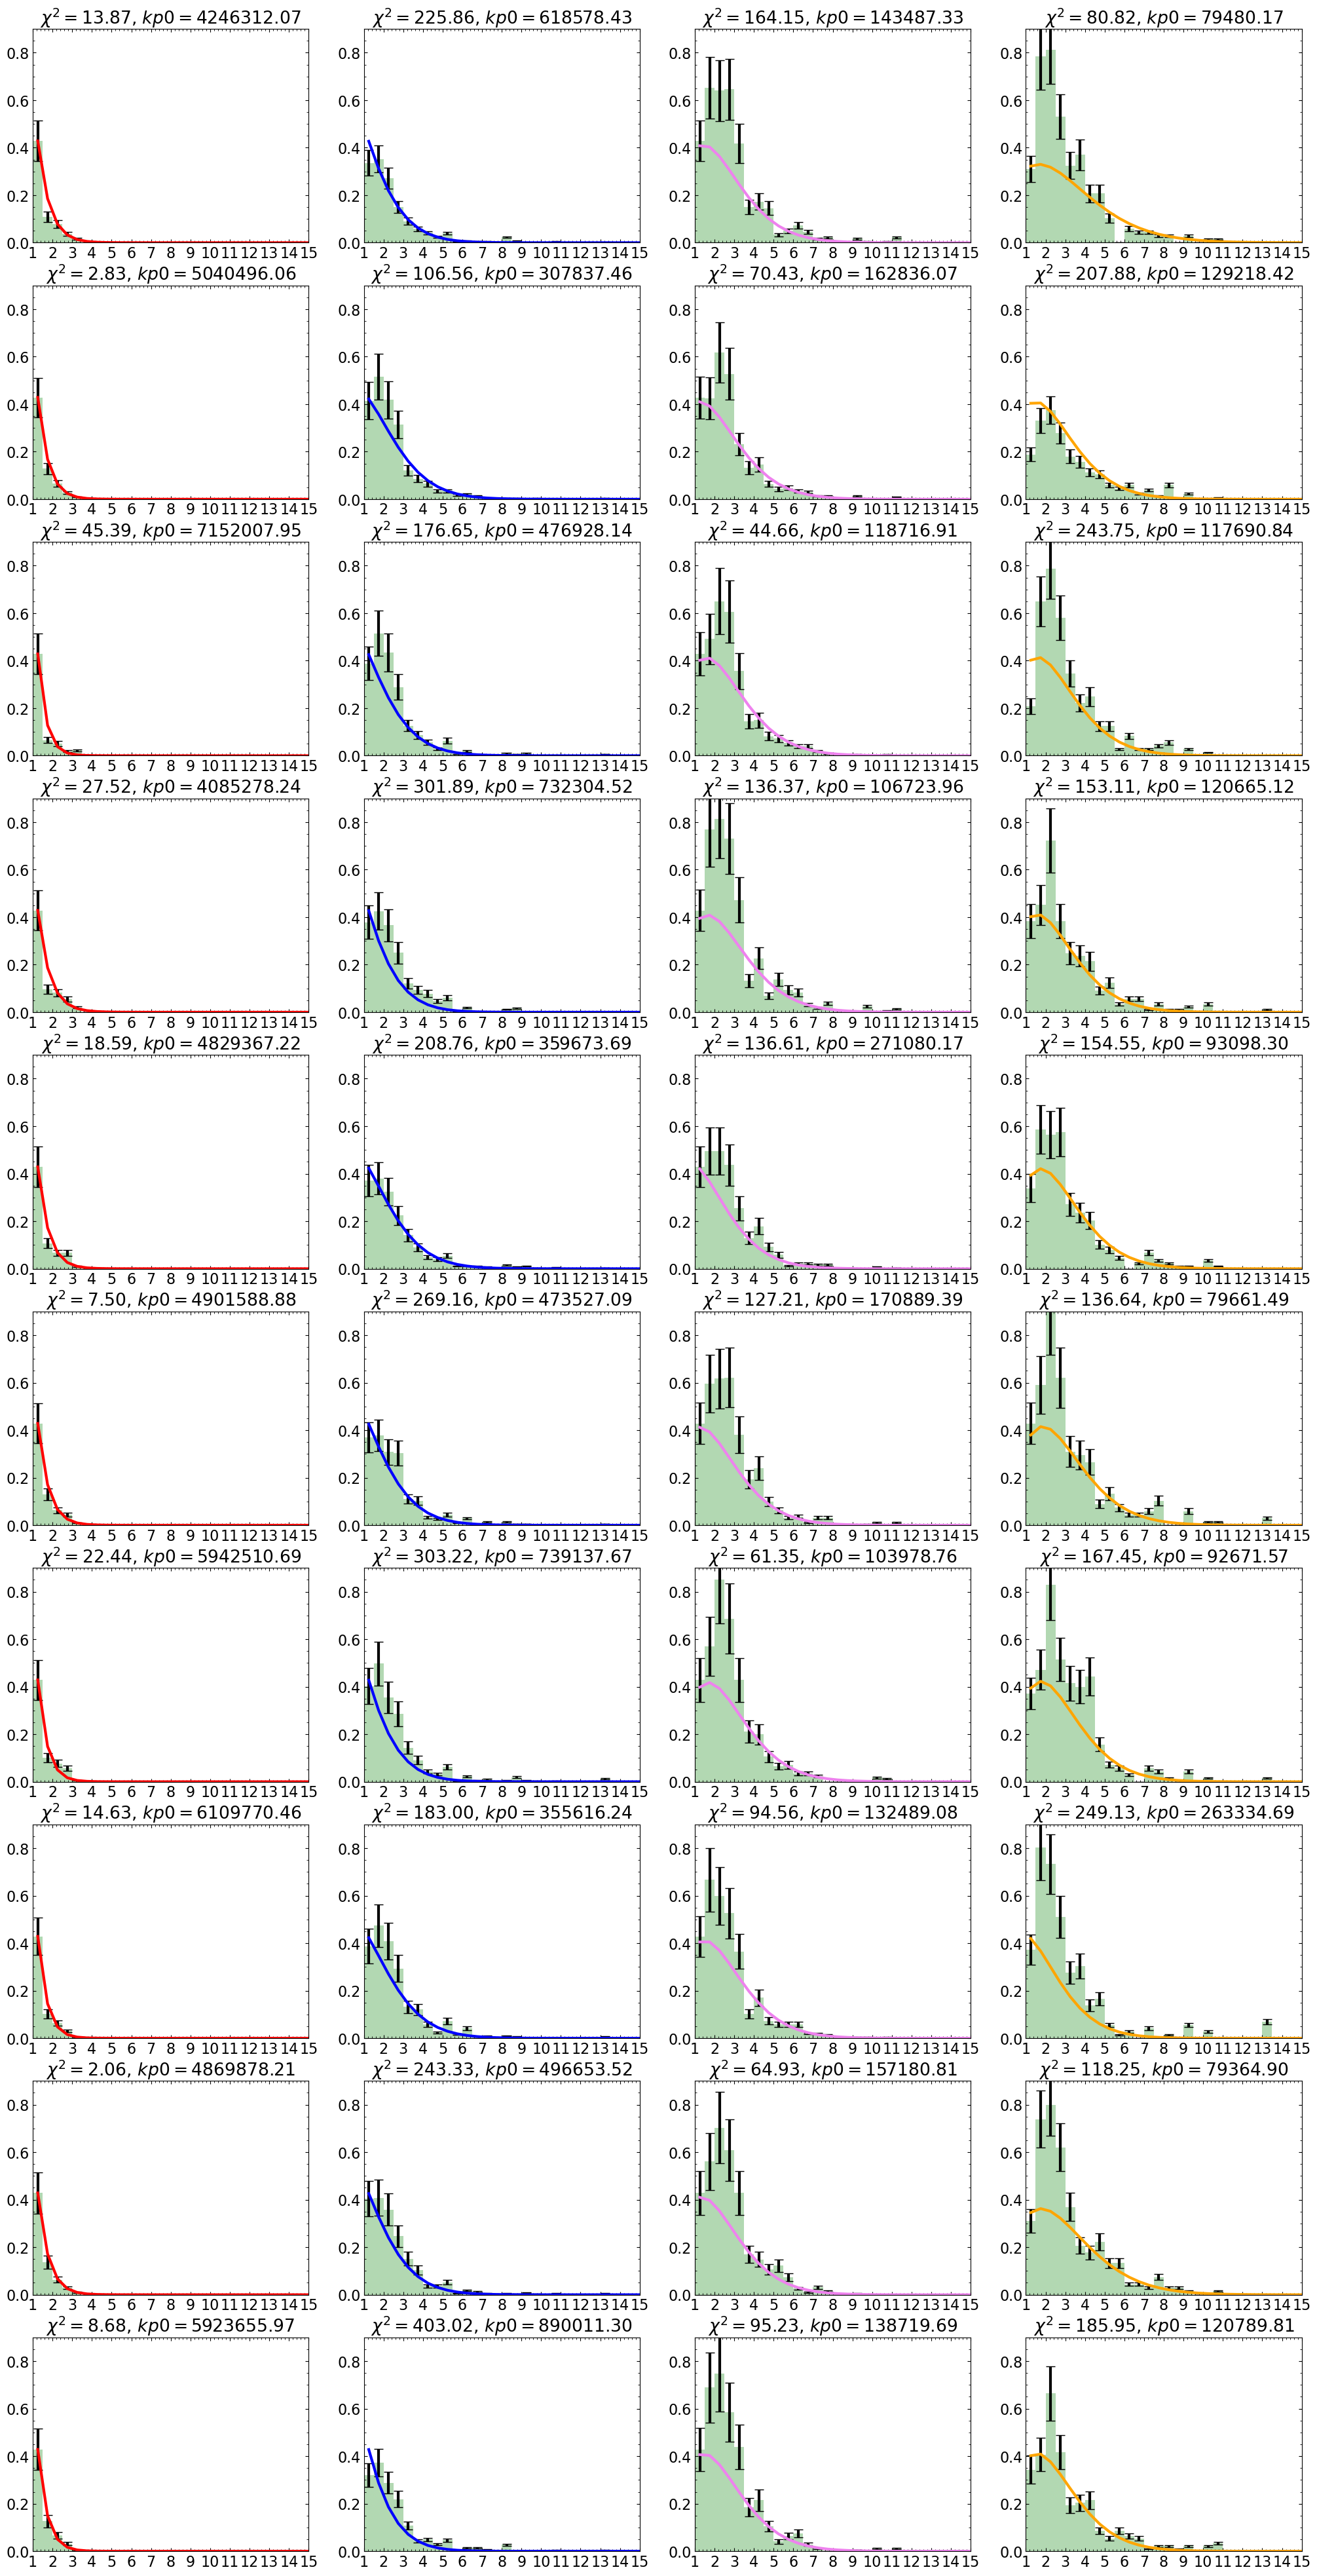

In [43]:
means, sigmas = plot_bootstrap_results(bootstrap_results, num_boot, conts) 
save_fit_errors(sigmas, seed_len_types)
plt.show()

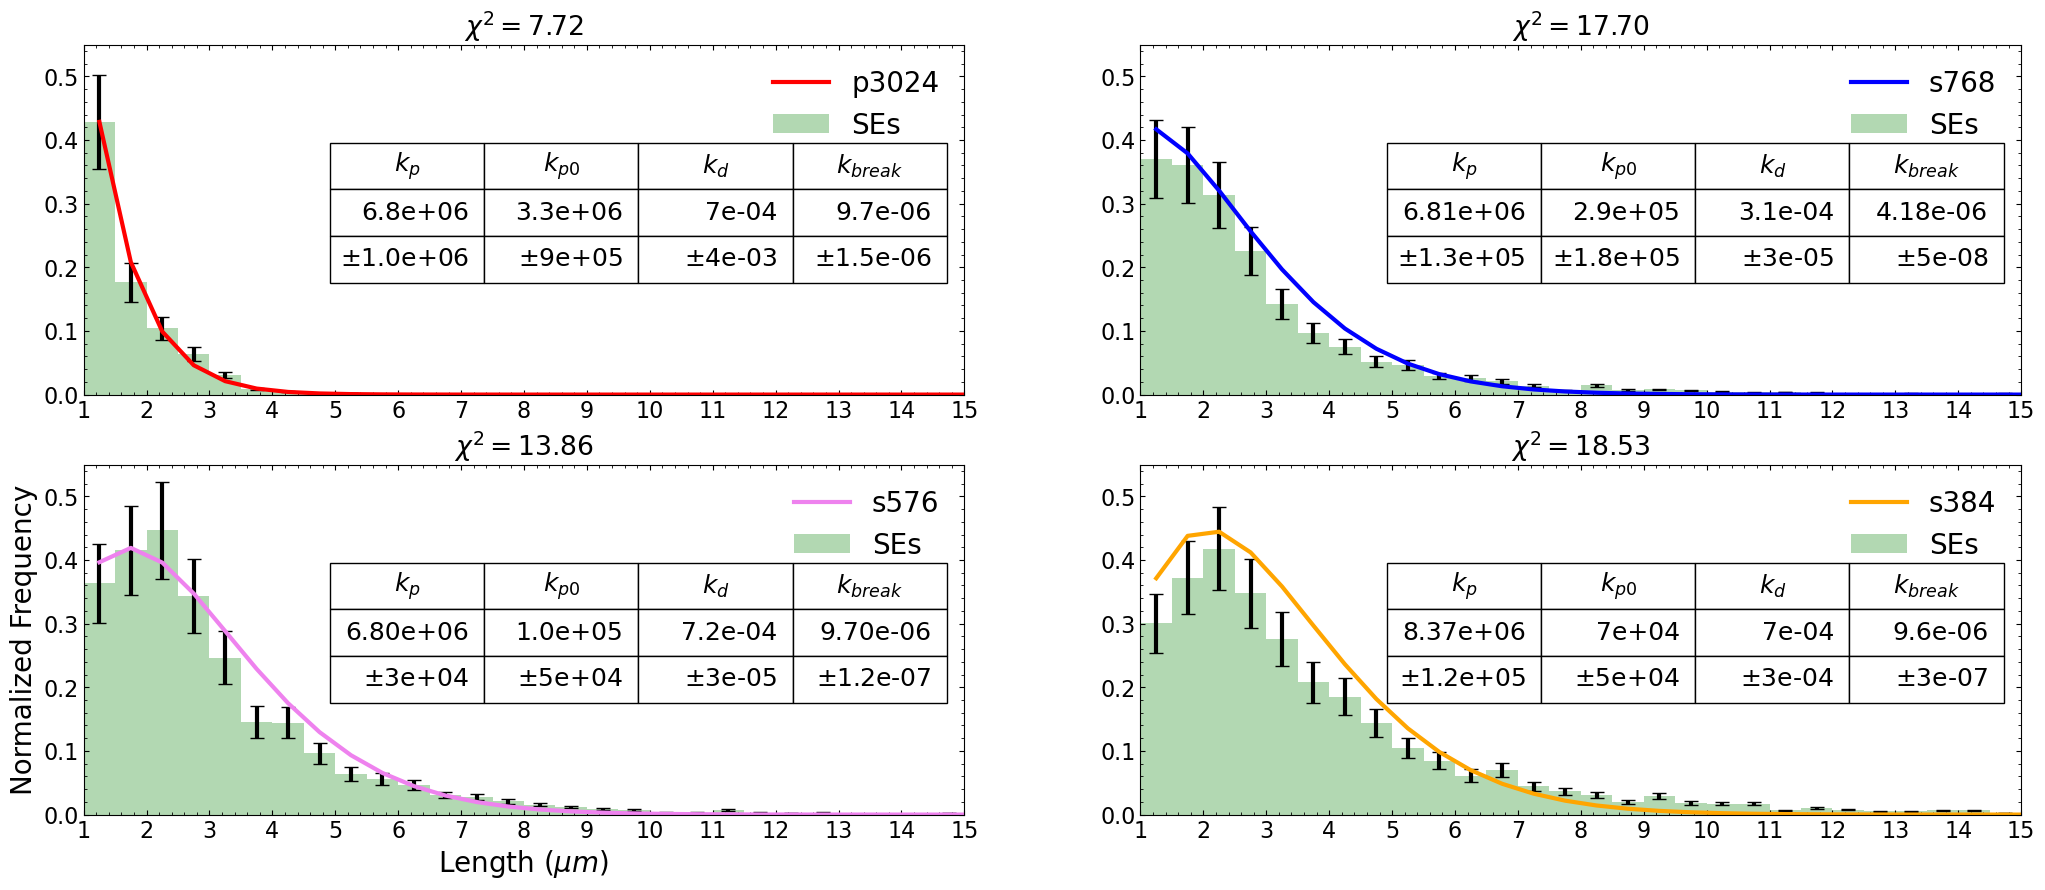

In [193]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
plot_hist(y_data_sets, y_error_sets, axs)
plot_model_results([fit_results[i].x for i in range(4)], y_data_sets, y_error_sets, axs, parr_error = sigmas)
plt.show()

Once again we need to collapse all of the sample data into an REs and an SEs distribution

In [67]:
#get sample data
for seed_len in seed_len_types:
    #two sided seed
    for slide_sample_id in data[f'ts {seed_len}']:
        re_data_df = run_quary(f"Select * From length_distributions Where slide_sample_id = {slide_sample_id} and is_in_ts = 1.0 and length_type = 're';").set_index('slide_sample_id') #only select the re lengths which are part of a ts tube
        data[f'ts {seed_len}'][slide_sample_id]['re_length_distribution'] = [len / pixel_per_um for len in re_data_df.loc[:]['lengths'].tolist()]
        se_data_df = run_quary(f"Select * From length_distributions Where slide_sample_id = {slide_sample_id} and is_in_ts = 1.0 and length_type = 'se';").set_index('slide_sample_id') #only select the re lengths which are part of a ts tube
        data[f'ts {seed_len}'][slide_sample_id]['se_length_distribution'] = [len / pixel_per_um for len in se_data_df.loc[:]['lengths'].tolist()]

In [68]:
bins = [1 + i*1.25 for i in range(0,13)] #use the same bins for all plots
x_data = np.array([j+0.625 for j in bins[0:-1]]) #get x data points from the bins (center point of each bin)

re_len_dists, se_len_dists = [], []
for i in range(len(seed_len_types)): #for seed type
    re_len_dist, se_len_dist = [], []
    seed_len = seed_len_types[i]
    for slide_sample_id in data[f'ts {seed_len}']: #for each sample
        sample = data[f'ts {seed_len}'][slide_sample_id]
        re_len_dist.extend(sample['re_length_distribution']) #combine the length distributions into one list
        se_len_dist.extend(sample['se_length_distribution'])
    
    re_len_dists.append(re_len_dist)
    se_len_dists.append(se_len_dist)

In [69]:
re_y_data_sets, se_y_data_sets = [get_ydata(re_len_dists[i]) for i in range(len(seed_len_types))], [get_ydata(se_len_dists[i]) for i in range(len(seed_len_types))]
re_y_error_sets, se_y_error_sets = [get_yerror(re_len_dists[i]) for i in range(len(seed_len_types))], [get_yerror(se_len_dists[i]) for i in range(len(seed_len_types))]

In [142]:
def plot_ts_hist(re_y_data_sets, se_y_data_sets, re_y_error_sets, se_y_error_sets, axs):
    for i in range(3): #for each seed type
        re_y_axis = [0,1,2,3][i] #determine which row
        re_x_axis = 0
        se_y_axis = [0,1,2,3][i]
        se_x_axis = 1

        re_y_data = re_y_data_sets[i] #get the seed's y data
        re_y_error = re_y_error_sets[i] #get the seed's error bars
        se_y_data = se_y_data_sets[i]
        se_y_error = se_y_error_sets[i]

        axs[re_y_axis, re_x_axis].bar(x_data, re_y_data, alpha = 0.3, label = 'REs', color = 'b', yerr = re_y_error, width = 1.25, capsize = 5)
        axs[se_y_axis, se_x_axis].bar(x_data, se_y_data, alpha = 0.3, label = 'SEs', color = 'g', yerr = se_y_error, width = 1.25, capsize = 5)
        axs[re_y_axis, re_x_axis].set_xlim(15,1)
        axs[se_y_axis, se_x_axis].set_xlim(1,15)
        axs[re_y_axis, re_x_axis].set_xticks(np.arange(1, 16, step = 1), np.arange(1, 16, step = 1))
        axs[se_y_axis, se_x_axis].set_xticks(np.arange(1, 16, step = 1), np.arange(1, 16, step = 1))
        axs[re_y_axis, re_x_axis].set_ylim(0,0.8)
        axs[se_y_axis, se_x_axis].set_ylim(0,0.8)
        axs[se_y_axis, se_x_axis].legend(prop={'size': 25}, frameon=False)
        axs[re_y_axis, re_x_axis].legend(prop={'size': 25}, frameon=False)


    axs[2,0].set_xlabel('Length ($\mu m$)', fontsize = 20)
    axs[2,0].set_ylabel('Normalized Frequency', fontsize = 20)

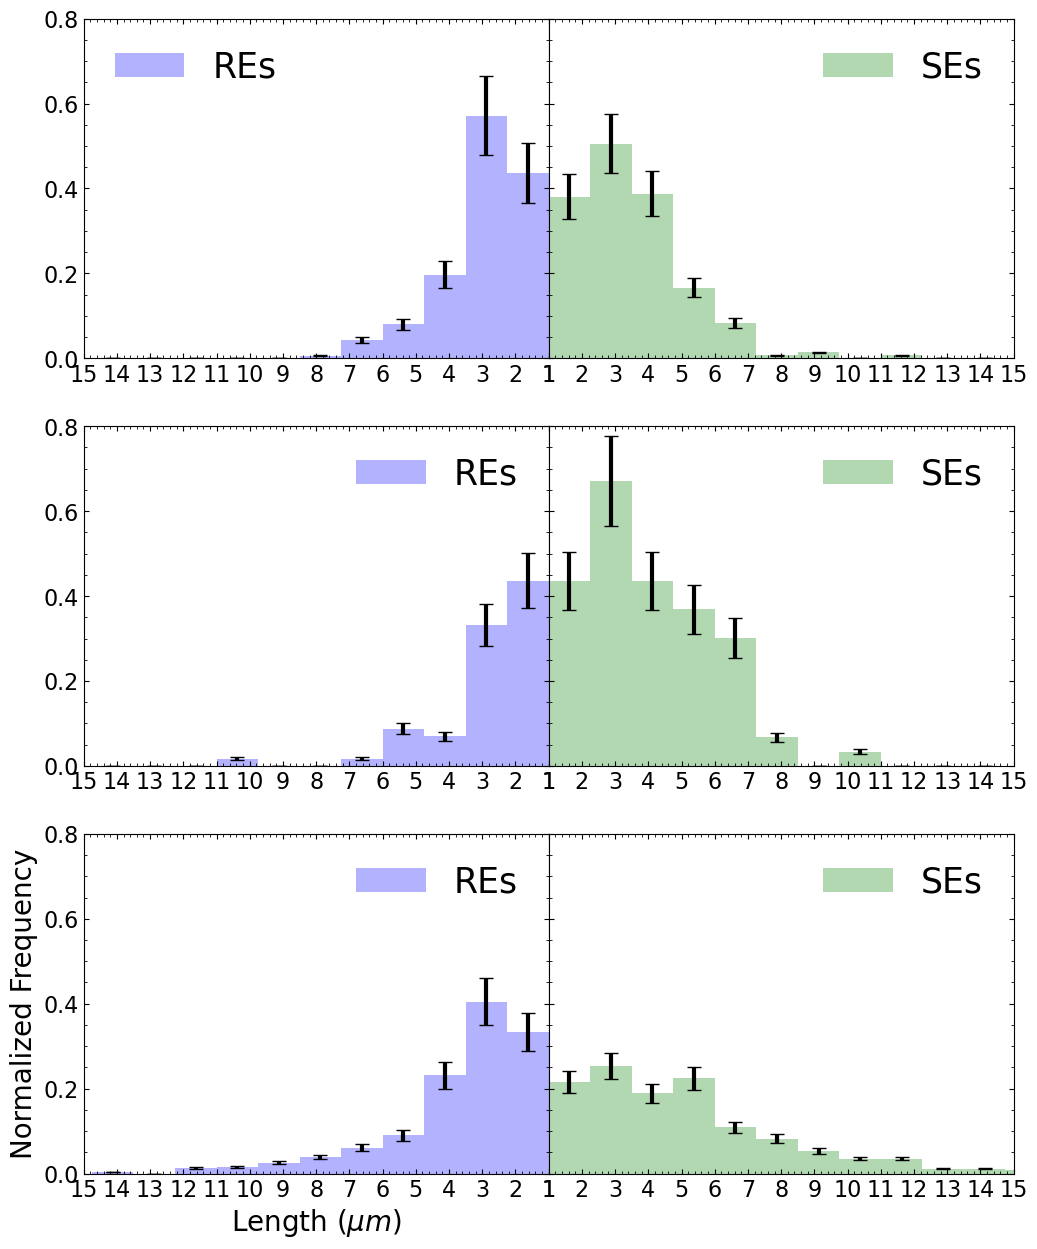

In [146]:
fig, axs = plt.subplots(3,2, figsize = (12,15), sharey='row')
plot_ts_hist(re_y_data_sets, se_y_data_sets, re_y_error_sets, se_y_error_sets, axs)
fig.subplots_adjust(wspace=0)
plt.show()

Since our histogram bins are now 1.25nm wide and we have 12 of them in total: 
- $N_b$ = 1049 tiles
- $l_b$ = 1.25 nm
- $n_{max}$ = 12

In [72]:
conts = [1049.0, 1.25, 13.0, 12.0, 5.25 * 24 * 60 * 60, 500000.0] #tiles, nm bin width, nm nanotube diameter, 5.25 days in seconds, num steps
conts.append(conts[4] / conts[5])  #h
conts.append(0.09 * 10**(-9)) #initial seed concentration 0.09nM

Once again lets make an initial guess for this data

In [104]:
re_parr0s = parr0s
se_parr0s = parr0s

re_parr0s[0][1] = 1e+06
se_parr0s[0][1] = 1e+06

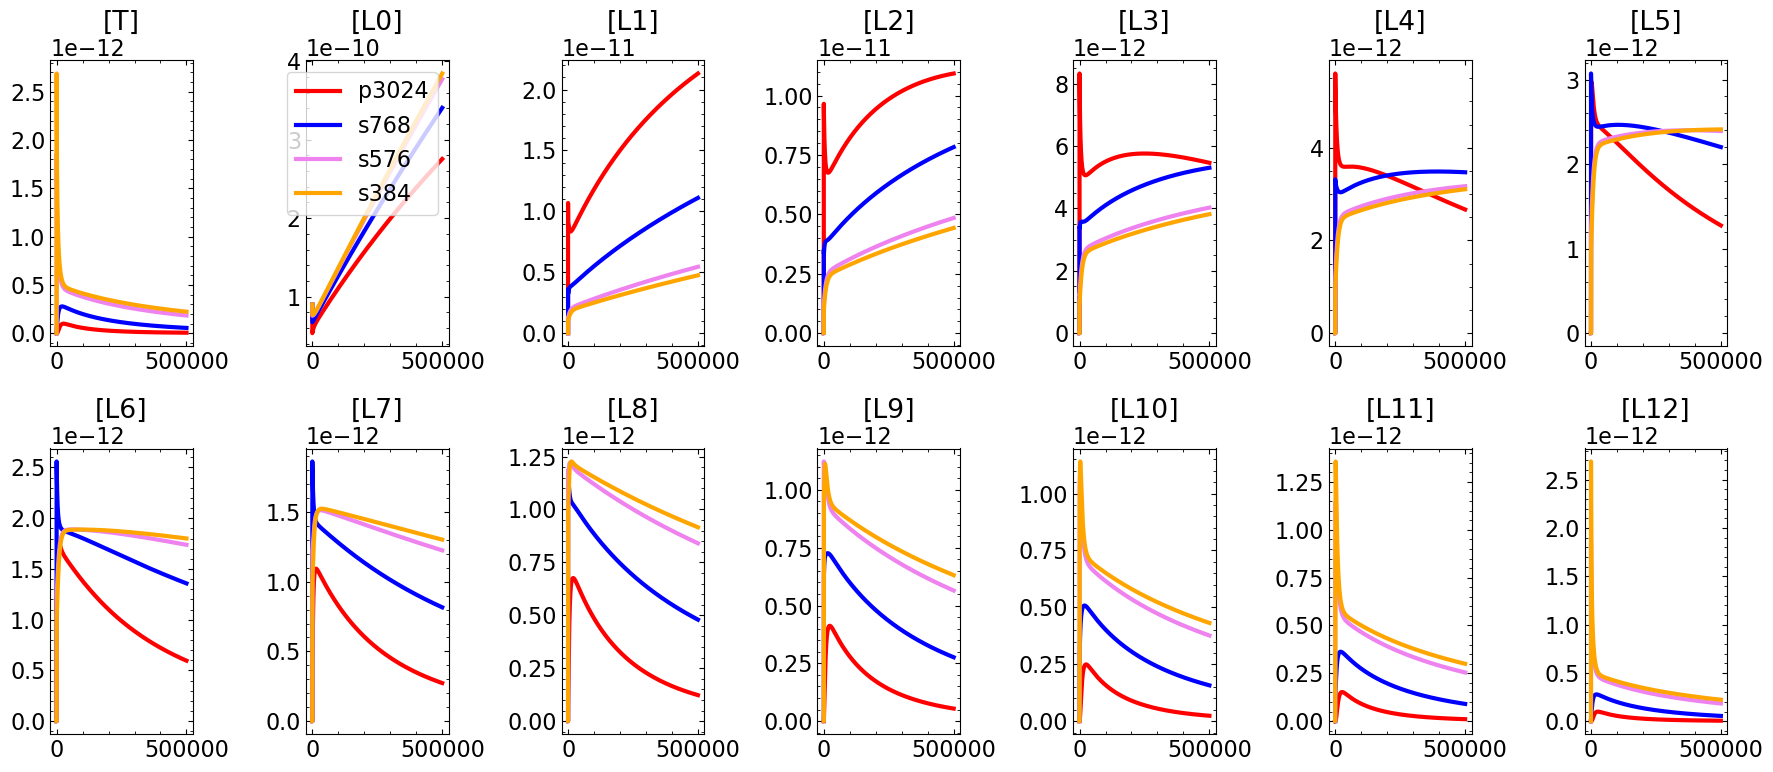

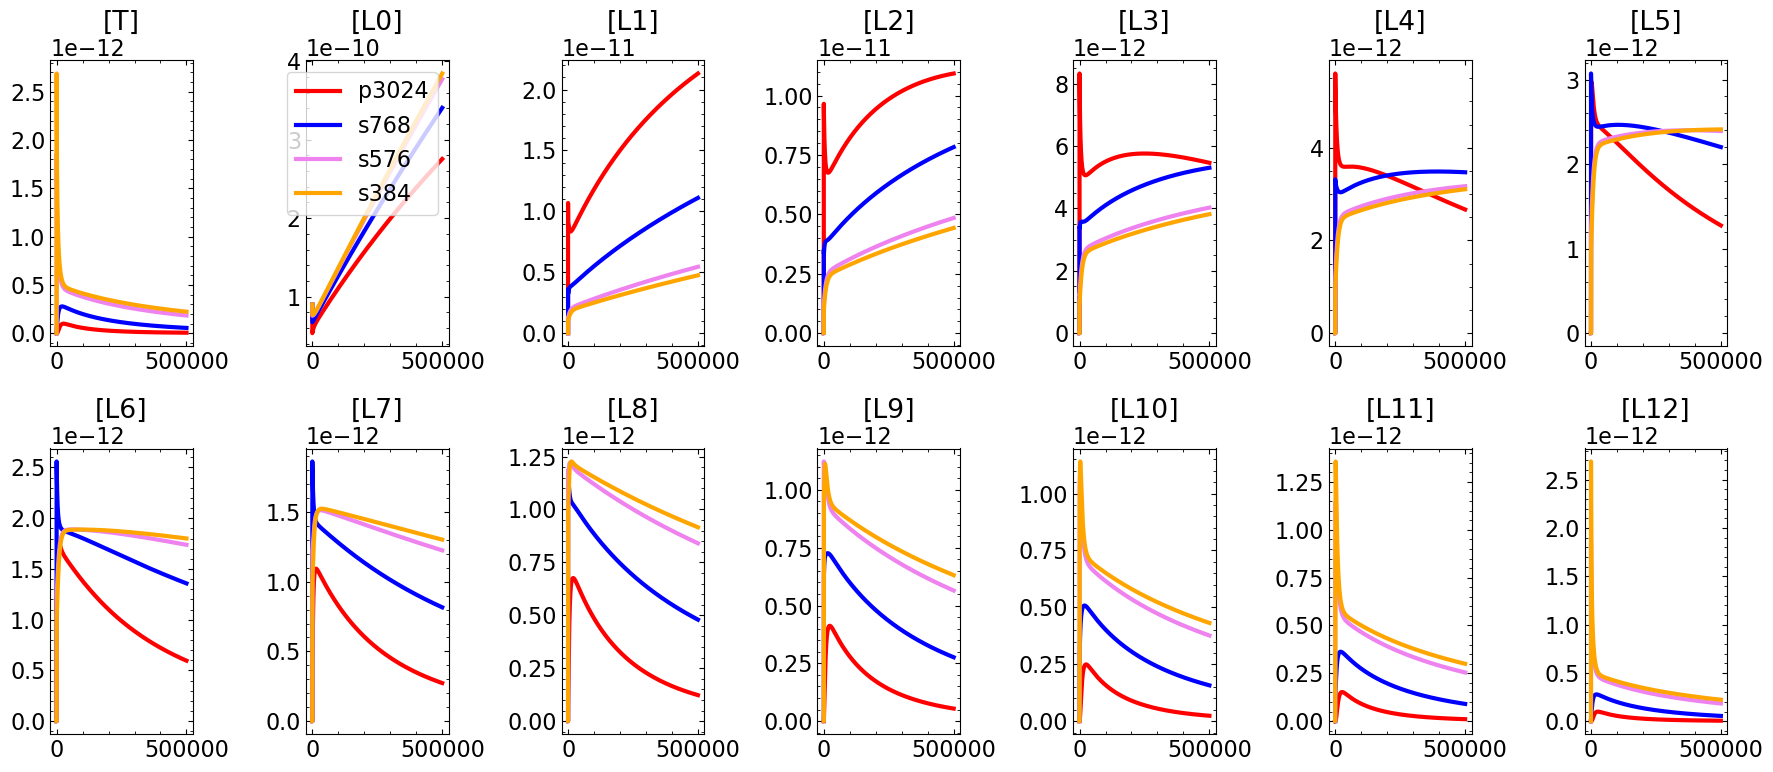

In [105]:
plot_time_dependence([L(re_parr0s[i], N_nucls[i], conts) for i in range(len(seed_len_types))], conts)
plt.show()
plot_time_dependence([L(se_parr0s[i], N_nucls[i], conts) for i in range(len(seed_len_types))], conts)
plt.show()

In [147]:
def plot_ts_model_results(re_parrs, se_parrs,re_y_data_sets, se_y_data_sets, re_y_error_sets, se_y_error_sets, axs):
    re_L_mats, se_L_mats = [L(re_parrs[i], N_nucls[i], conts) for i in range(len(seed_len_types))], [L(se_parrs[i], N_nucls[i], conts) for i in range(len(seed_len_types))]
    re_models, se_models = [L_mat[-1,1:int(conts[3]) + 1] / basic_simp(x_data, L_mat[-1,1:int(conts[3]) + 1]) for L_mat in re_L_mats], [L_mat[-1,1:int(conts[3]) + 1] / basic_simp(x_data, L_mat[-1,1:int(conts[3]) + 1]) for L_mat in se_L_mats]
    re_chi_squares, se_chi_squares = [chi_square(re_y_data_sets[i], re_y_error_sets[i], re_models[i], conts) for i in range(len(seed_len_types))], [chi_square(se_y_data_sets[i], se_y_error_sets[i], se_models[i], conts) for i in range(len(seed_len_types))]
    
    for i in range(3)[::-1]: #for seed type
        re_y_axis = [0,1,2,3][i] #determine which row
        re_x_axis = 0
        se_y_axis = [0,1,2,3][i]
        se_x_axis = 1

        axs[re_y_axis, re_x_axis].plot(x_data, re_models[i], color = colors[i], label = seed_len_types[i])
        axs[se_y_axis, se_x_axis].plot(x_data, se_models[i], color = colors[i], label = seed_len_types[i])

        axs[re_y_axis, re_x_axis].set_title(f'$\chi^2 = {re_chi_squares[i]:.2f}$')
        axs[se_y_axis, se_x_axis].set_title(f'$\chi^2 = {se_chi_squares[i]:.2f}$')

        axs[se_y_axis, se_x_axis].legend(prop={'size': 15}, frameon=False)
        axs[re_y_axis, re_x_axis].legend(prop={'size': 15}, frameon=False, loc= 'upper left')

        col_labels = ['$k_p$', '$k_{{p0}}$', '$k_d$', '$k_{{break}}$']

        re_table_vals = [['%.2e' % j for j in re_parrs[i]]]
        se_table_vals = [['%.2e' % j for j in se_parrs[i]]]
        re_table = axs[re_y_axis, re_x_axis].table(cellText = re_table_vals, bbox = [0.1,0.55,0.7,0.2], colLabels = col_labels, colWidths= [0.1]*4)
        se_table = axs[se_y_axis, se_x_axis].table(cellText = se_table_vals, bbox = [0.28,0.55,0.7,0.2], colLabels = col_labels, colWidths= [0.1]*4)
        re_table.auto_set_font_size(False)
        se_table.auto_set_font_size(False)
        re_table.set_fontsize(12)
        se_table.set_fontsize(12)



In [107]:
@njit
def chi_square(y_data, y_error, model, cont, per_n = True):
    s = 0
    n_num = 0
    for n in range(int(cont[3])):
        if y_error[n] != 0:
            n_num += 1
            s += ((y_data[n] - model[n])/(y_error[n]))**2

    if per_n:
        return s/n_num
    else:
        return s 

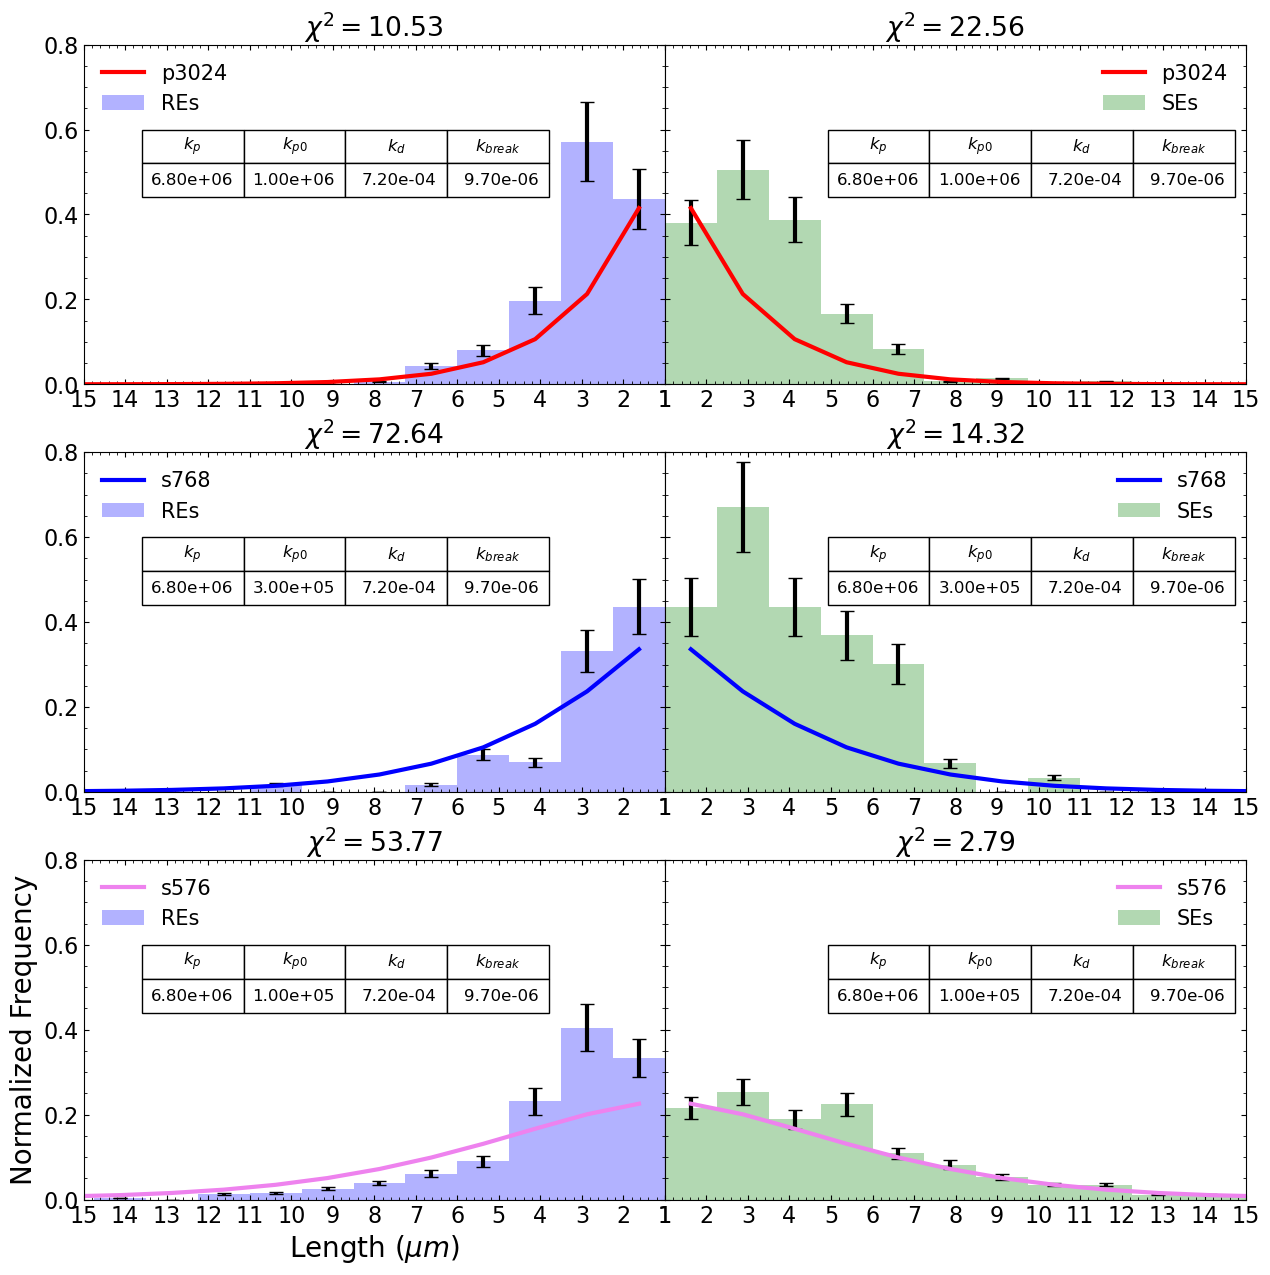

In [149]:
fig, axs = plt.subplots(3,2, figsize = (15,15), sharey='row')
plot_ts_hist(re_y_data_sets, se_y_data_sets, re_y_error_sets, se_y_error_sets, axs)
fig.subplots_adjust(wspace=0)
plot_ts_model_results(re_parr0s, se_parr0s, re_y_data_sets, se_y_data_sets, re_y_error_sets, se_y_error_sets, axs)
plt.show()

In [109]:
re_fit_results = Parallel(n_jobs=4, verbose=10)(delayed(least_squares)(equations, re_parr0s[i], bounds = bounds, args=(N_nucls[i], re_y_data_sets[i], re_y_error_sets[i], conts)) for i in range(len(seed_len_types)))
se_fit_results = Parallel(n_jobs=4, verbose=10)(delayed(least_squares)(equations, se_parr0s[i], bounds = bounds, args=(N_nucls[i], se_y_data_sets[i], se_y_error_sets[i], conts)) for i in range(len(seed_len_types)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.3min remaining:  4.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.8min finished


In [110]:
save_fit_results([re_fit_results[i].x for i in range(4)], [f're {seed}' for seed in seed_len_types])
save_fit_results([se_fit_results[i].x for i in range(4)], [f'se {seed}' for seed in seed_len_types])

In [111]:
re_fit_L_mats, se_fit_L_mats = [L(re_fit_results[i].x, N_nucls[i], conts) for i in range(len(seed_len_types))], [L(se_fit_results[i].x, N_nucls[i], conts) for i in range(len(seed_len_types))]
re_fit_models, se_fit_models = [L_mat[-1,1:30] / basic_simp(x_data, L_mat[-1,1:30]) for L_mat in re_fit_L_mats],  [L_mat[-1,1:30] / basic_simp(x_data, L_mat[-1,1:30]) for L_mat in se_fit_L_mats]

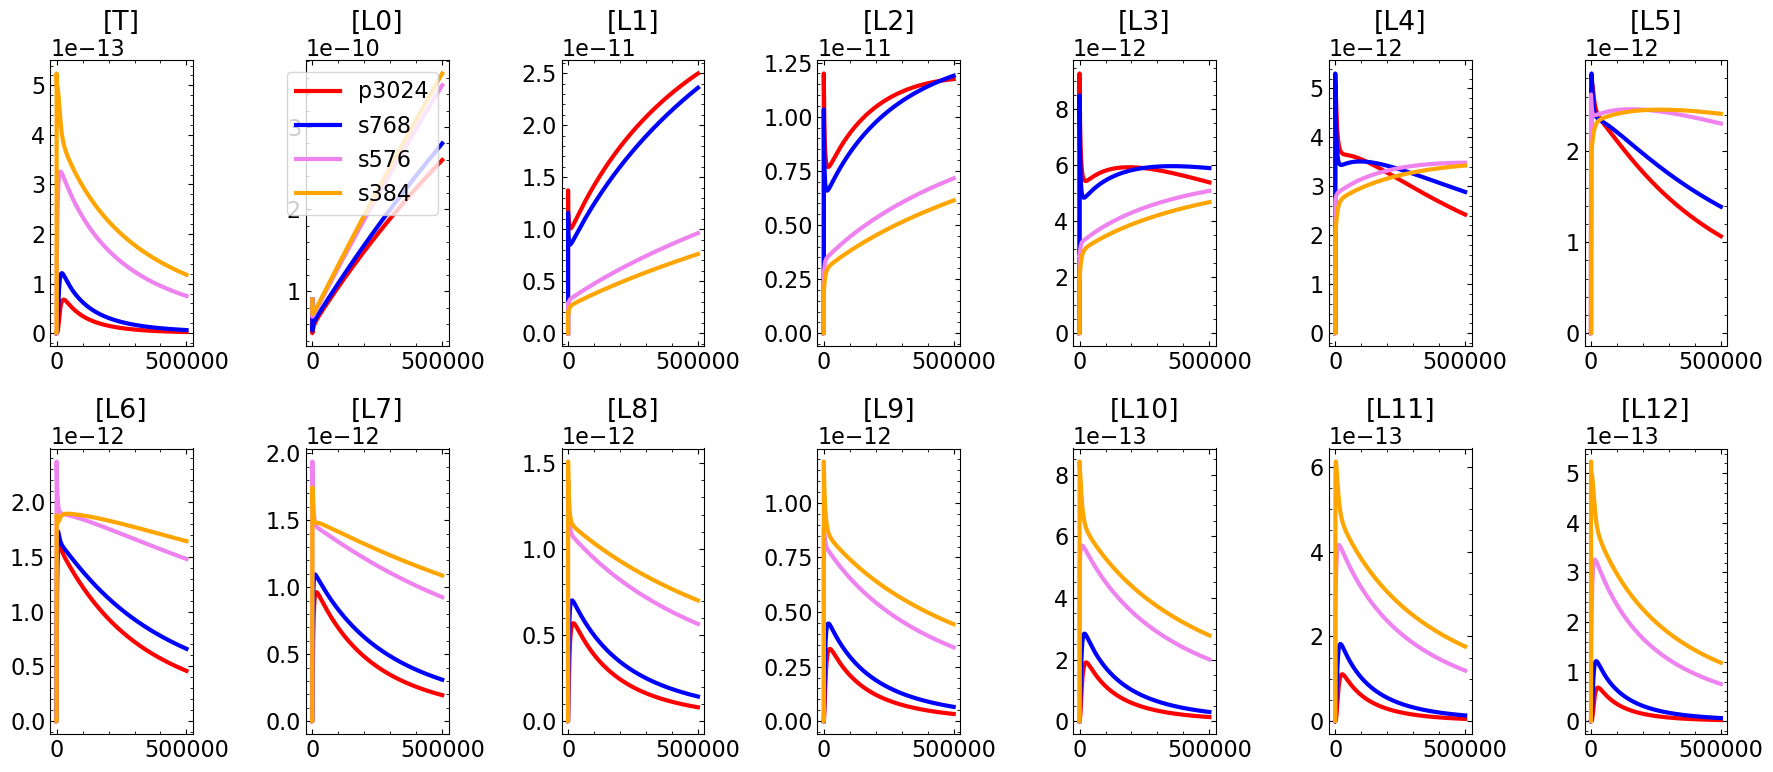

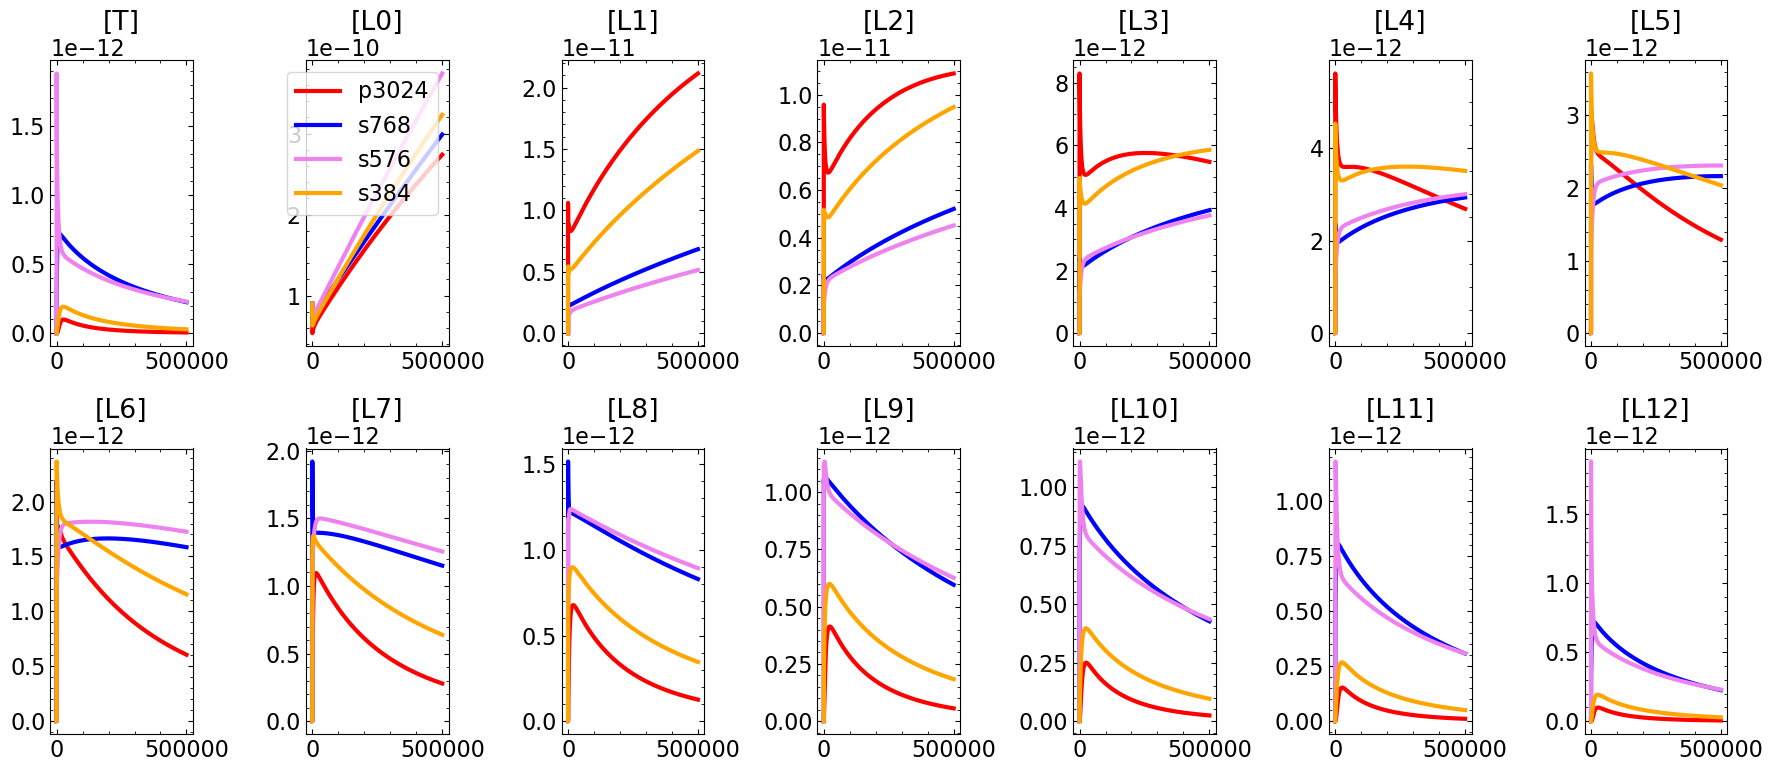

In [112]:
plot_time_dependence(re_fit_L_mats, conts)
plt.show()
plot_time_dependence(se_fit_L_mats, conts)
plt.show()

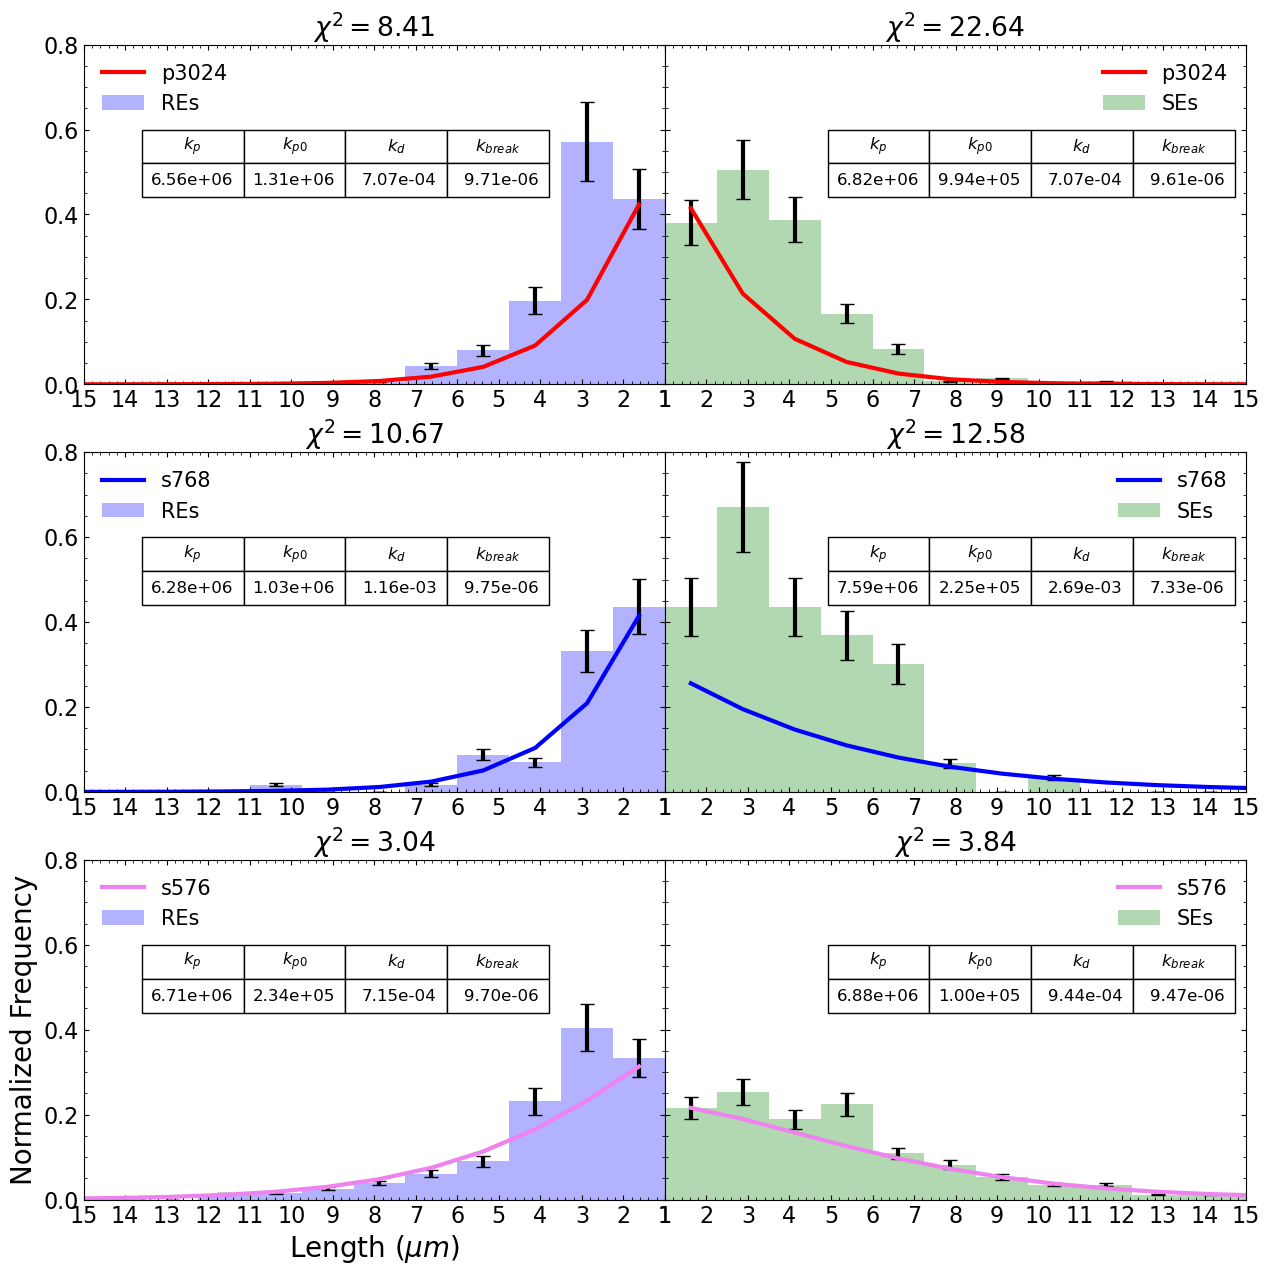

In [151]:
fig, axs = plt.subplots(3,2, figsize = (15,15), sharey='row')
plot_ts_hist(re_y_data_sets, se_y_data_sets, re_y_error_sets, se_y_error_sets, axs)
fig.subplots_adjust(wspace=0)
plot_ts_model_results([re_fit_results[i].x for i in range(4)], [se_fit_results[i].x for i in range(4)], re_y_data_sets, se_y_data_sets, re_y_error_sets, se_y_error_sets, axs)
plt.show()

We will also use bootstrapping in the same way to get the error values for these

In [114]:
re_bootstrap_results = Parallel(n_jobs= -1, verbose=10)(delayed(get_boot_fit)(re_len_dists[i], re_parr0s[i], bounds, N_nucls[i], conts) for i in range(4) for _ in range(num_boot)) #order in this array is p3024_set1, p3024_set2, ..., p3024_set_num_boot, s768set_1, etc....

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   2 out of  40 | elapsed:  4.8min remaining: 91.7min
[Parallel(n_jobs=-1)]: Done   7 out of  40 | elapsed:  5.4min remaining: 25.3min
[Parallel(n_jobs=-1)]: Done  12 out of  40 | elapsed:  6.0min remaining: 14.0min
[Parallel(n_jobs=-1)]: Done  17 out of  40 | elapsed:  6.8min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:  7.6min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:  8.3min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:  9.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed: 25.8min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 53.9min finished


p3024 kp: 7.15e+06 +- 4.72e+05 kp0: 9.55e+05 +- 2.52e+05 kd: 2.12e-03 +- 1.05e-03 kbreak: 8.46e-06 +- 1.21e-06
s768 kp: 5.61e+06 +- 7.46e+05 kp0: 2.14e+06 +- 1.27e+06 kd: 4.57e-03 +- 4.44e-03 kbreak: 5.88e-06 +- 4.08e-06
s576 kp: 6.41e+06 +- 1.96e+05 kp0: 6.70e+05 +- 2.85e+05 kd: 1.21e-03 +- 3.15e-04 kbreak: 9.53e-06 +- 1.66e-07
s384 kp: 6.77e+06 +- 2.38e+06 kp0: 1.10e+06 +- 2.97e+06 kd: 2.01e-03 +- 2.80e-03 kbreak: 8.86e-06 +- 1.50e-06


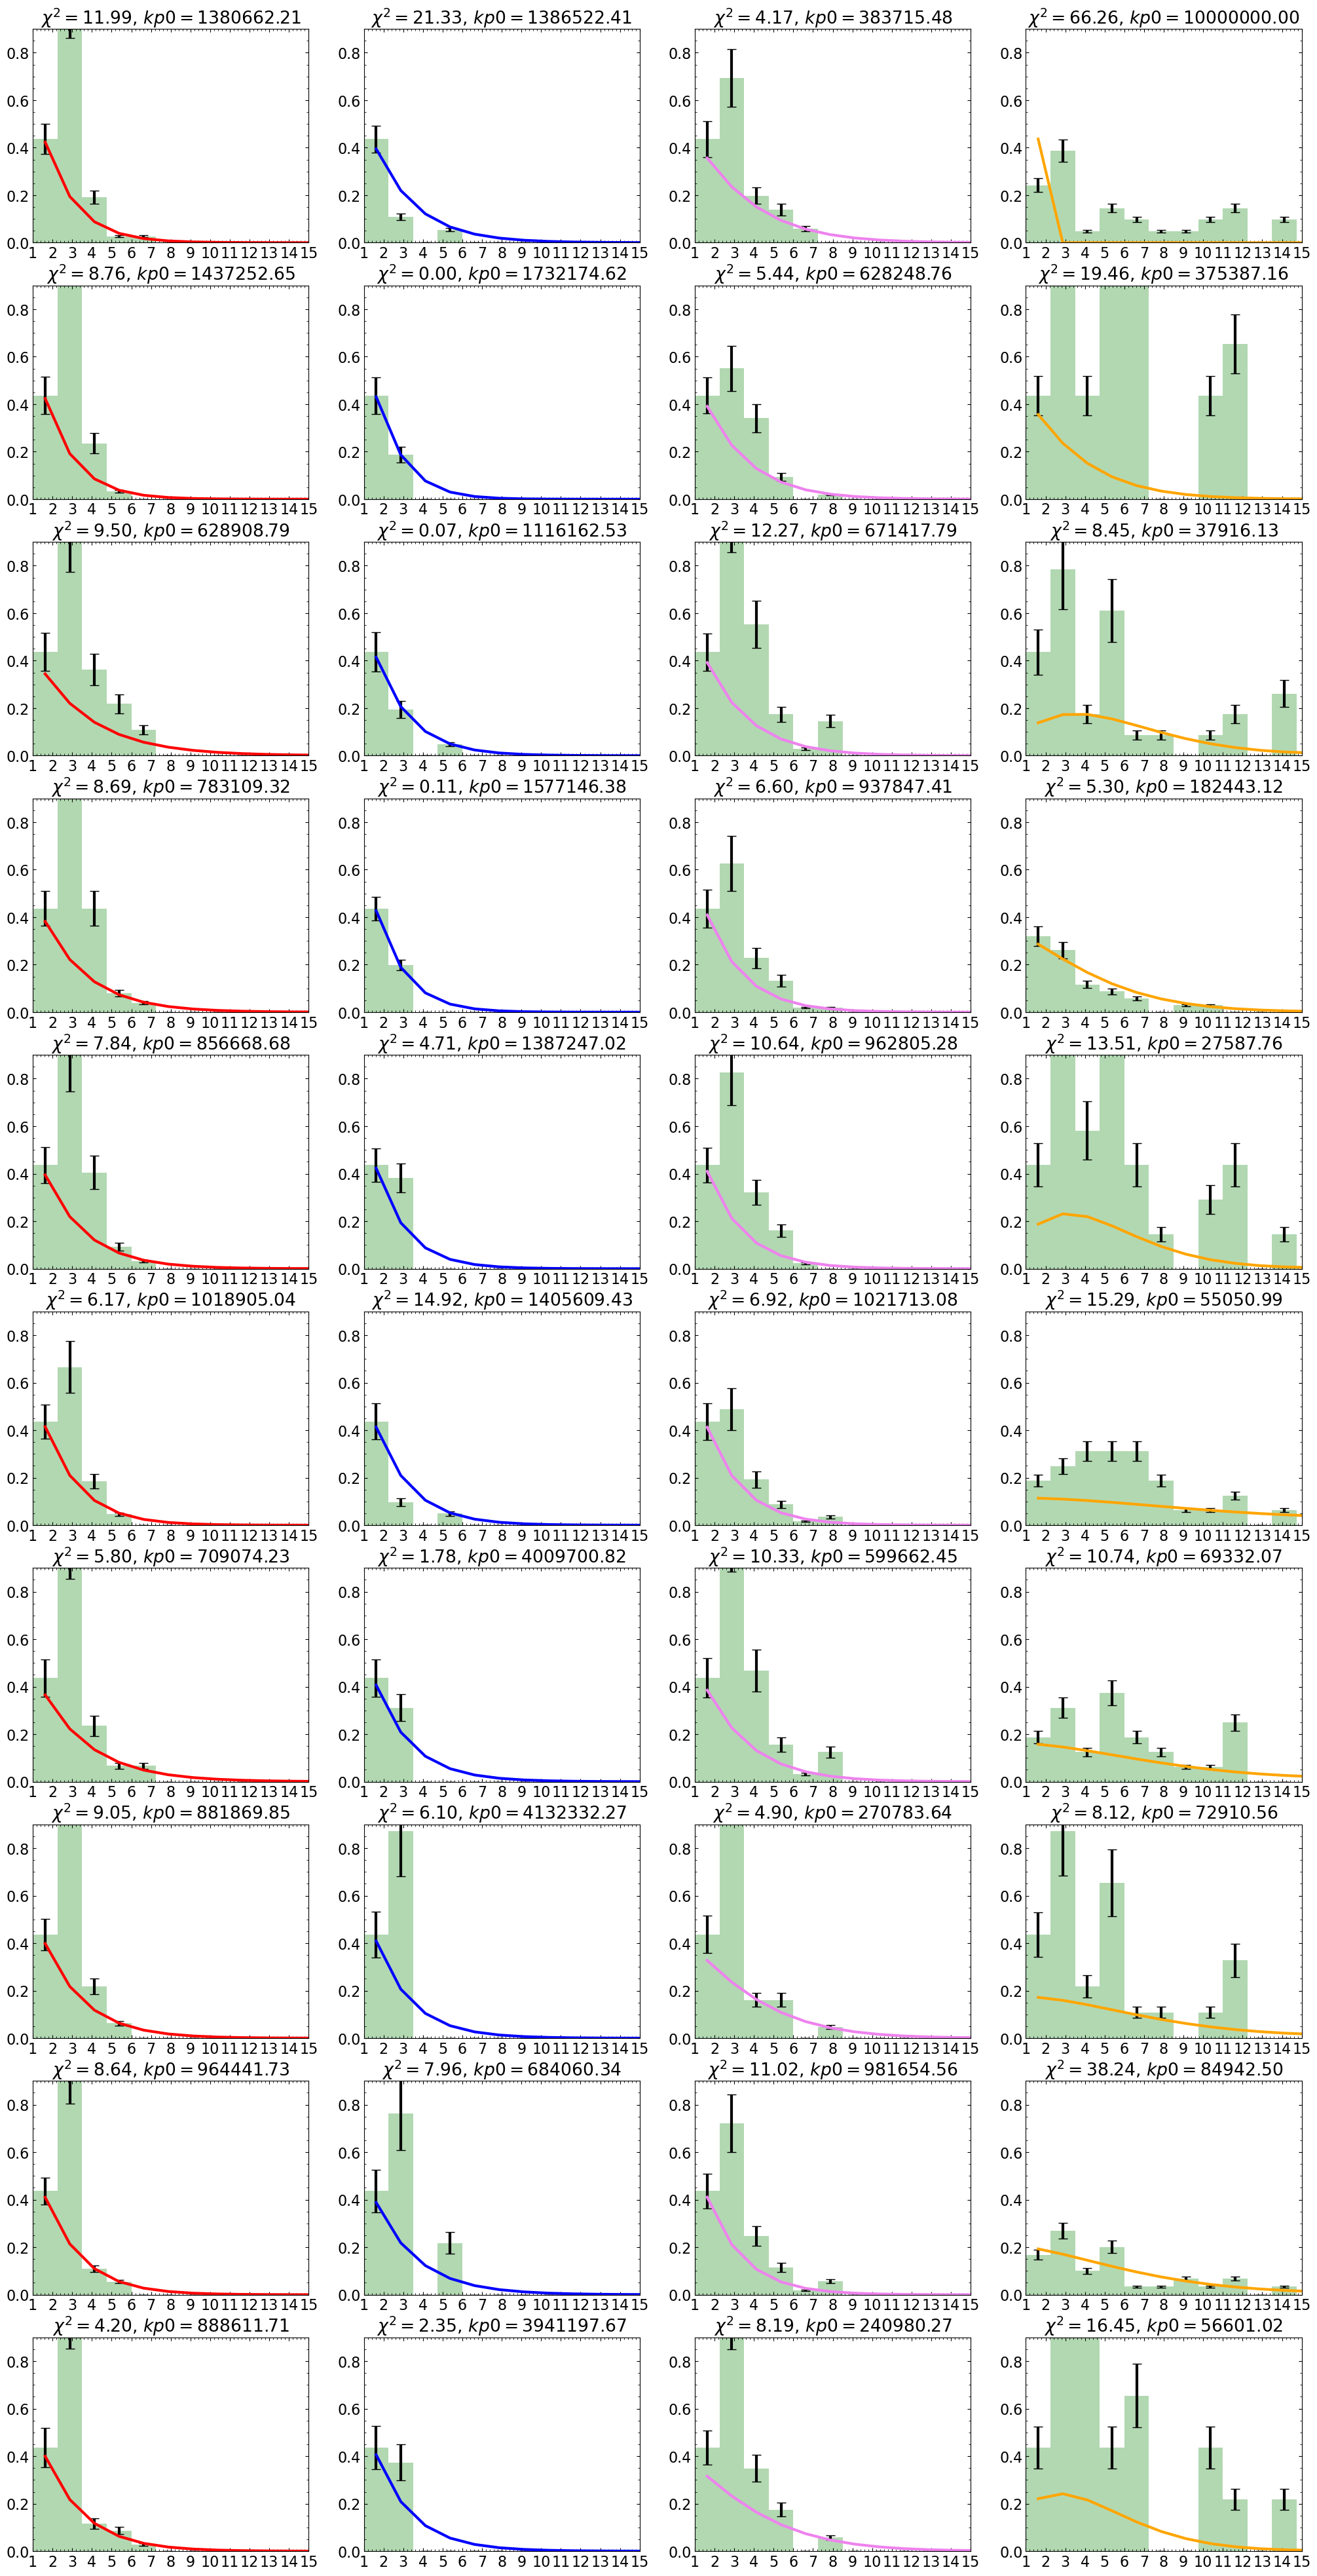

In [115]:
means_re, sigmas_re = plot_bootstrap_results(re_bootstrap_results, num_boot, conts)
plt.show()

In [116]:
se_bootstrap_results = Parallel(n_jobs= -1, verbose=10)(delayed(get_boot_fit)(se_len_dists[i], se_parr0s[i], bounds, N_nucls[i], conts) for i in range(4) for _ in range(num_boot))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   2 out of  40 | elapsed:  4.0min remaining: 75.7min
[Parallel(n_jobs=-1)]: Done   7 out of  40 | elapsed:  4.5min remaining: 21.3min
[Parallel(n_jobs=-1)]: Done  12 out of  40 | elapsed:  4.9min remaining: 11.4min
[Parallel(n_jobs=-1)]: Done  17 out of  40 | elapsed:  5.1min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:  6.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:  8.5min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 10.6min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed: 34.7min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 170.7min finished


p3024 kp: 7.26e+06 +- 5.14e+05 kp0: 9.19e+05 +- 2.75e+05 kd: 2.41e-03 +- 1.17e-03 kbreak: 8.10e-06 +- 1.29e-06
s768 kp: 6.06e+06 +- 9.59e+05 kp0: 1.50e+06 +- 1.36e+06 kd: 6.47e-03 +- 4.33e-03 kbreak: 7.28e-06 +- 3.61e-06
s576 kp: 6.83e+06 +- 2.51e+05 kp0: 1.94e+05 +- 1.59e+05 kd: 1.11e-03 +- 5.86e-04 kbreak: 9.38e-06 +- 5.85e-07
s384 kp: 6.89e+06 +- 1.04e+06 kp0: 4.24e+05 +- 1.59e+05 kd: 2.88e-03 +- 3.56e-03 kbreak: 9.74e-06 +- 1.51e-07


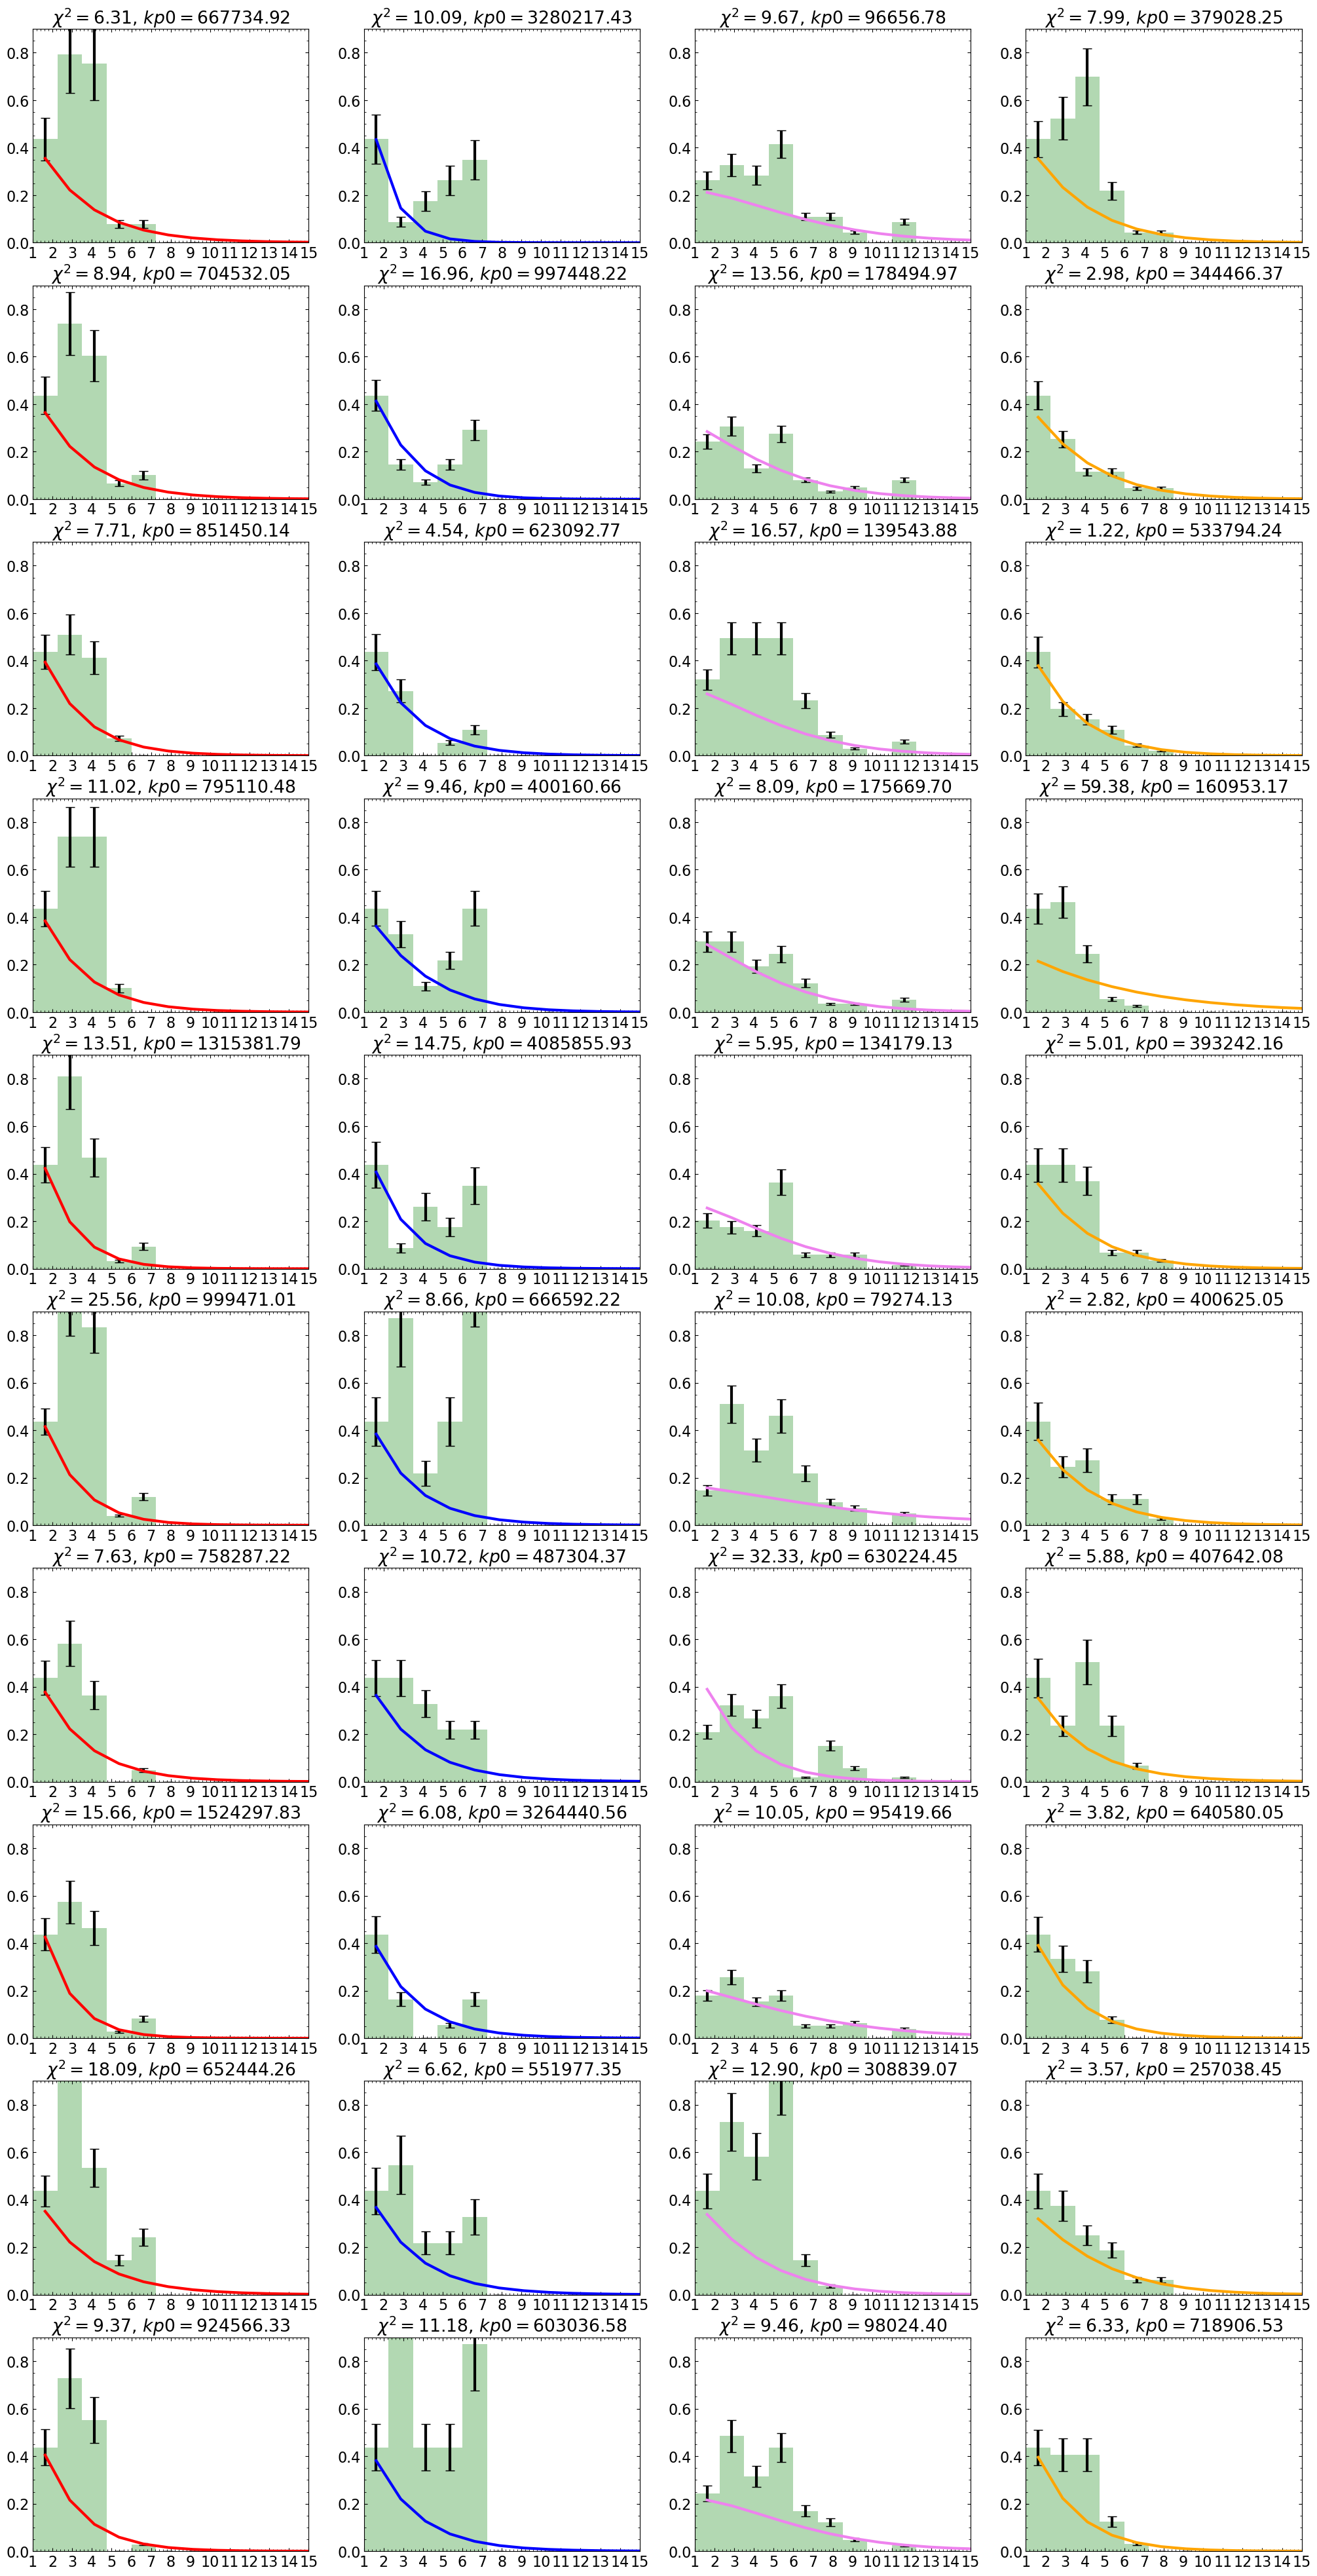

In [118]:
means_se, sigmas_se = plot_bootstrap_results(se_bootstrap_results, num_boot, conts) 
save_fit_errors(sigmas_re, [f're {seed}' for seed in seed_len_types])
save_fit_errors(sigmas_se, [f'se {seed}' for seed in seed_len_types])
plt.show()